In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
from statannotations.Annotator import Annotator

import warnings

import sys 
sys.path.append(r'..\utils') 
from utils import get_seaad_colors, format_box_plot

Box plots comparing macaque and human dendrite morphology features by Great Ape Consensus Taxonomy cluster 
- Remove Layer Aligned features
- Remove axon only cells

In [2]:
#human
# h_class_col =     'GA_RSC122-365_class_Corr'
# h_subclass_col =  'GA_RSC122-365_subclass_Corr'
# h_cluster_col =   'GA_RSC122-365_cluster_Corr'

h_class_col =     'GA_RSC-122-380_class_Corr_label'
h_subclass_col =  'GA_RSC-122-380_subclass_Corr_label'
h_cluster_col =   'GA_RSC-122-380_cluster_Corr_label'

#macaque
p_class_col =     'GA_RSC-204-380_class_Corr_label'
p_subclass_col =  'GA_RSC-204-380_subclass_Corr_label'
p_cluster_col =   'GA_RSC-204-380_cluster_Corr_label'

#rename to
class_col =     'GA_class'
subclass_col =  'GA_subclass'
cluster_col =   'GA_cluster'

In [3]:
#load data

output_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250529_seaad\macaque'
os.makedirs(output_dir, exist_ok=True)

#HUMAN
human_data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\dendrite'
# human_metadata = pd.read_csv(os.path.join(human_data_root, 'metadata.csv'))
human_metadata = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\metadata\20250204\Datalock_11_6_24.csv', encoding='latin1')
human_raw_feature_wide = pd.read_csv(os.path.join(human_data_root, 'RawFeatureWide.csv'))
human_metadata = human_metadata.rename(columns={h_class_col: class_col, h_subclass_col: subclass_col, h_cluster_col: cluster_col, 'cell_id': 'specimen_id'})
human_metadata['species'] = 'human'

#MACAQUE
macaque_data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\macaque\20250521'
macaque_metadata = pd.read_csv(os.path.join(macaque_data_root, 'macaque_species_compare.csv'))
macaque_raw_feature_wide = pd.read_csv(os.path.join(macaque_data_root, 'RawFeatureWide.csv'))
macaque_metadata = macaque_metadata[macaque_metadata.cell_specimen_id.isin(macaque_raw_feature_wide.specimen_id.tolist())]
macaque_metadata = macaque_metadata.rename(columns={p_class_col: class_col, p_subclass_col: subclass_col, p_cluster_col: cluster_col, 'cell_specimen_id': 'specimen_id'})
macaque_metadata['species'] = 'macaque'

#only keep human cells in the types that we have macaque for
human_metadata = human_metadata[human_metadata[cluster_col].isin(macaque_metadata[cluster_col].unique())]

# #remove layer aligned features 
# la_feats = ['soma_aligned_dist_from_pia', 'apical_dendrite_depth_pc_0', 'apical_dendrite_depth_pc_1', 'apical_dendrite_depth_pc_2', 'apical_dendrite_depth_pc_3', 'apical_dendrite_depth_pc_4']
# human_raw_feature_wide = human_raw_feature_wide[[x for x in human_raw_feature_wide.columns if not x in la_feats]]
# macaque_raw_feature_wide = macaque_raw_feature_wide[[x for x in macaque_raw_feature_wide if x in human_raw_feature_wide.columns]]

#combine data 
human_data = human_metadata[['specimen_id', subclass_col, cluster_col, 'species']].merge(human_raw_feature_wide, how='inner', on='specimen_id')
macaque_data = macaque_metadata[['specimen_id', subclass_col, cluster_col, 'species']].merge(macaque_raw_feature_wide, how='inner', on='specimen_id')
data = pd.concat([human_data, macaque_data])

#remove missing ttype labels
data = data[~data[cluster_col].isna()]

color_dict = get_seaad_colors()

In [4]:
data

specimen_id GA_subclass GA_cluster  species  apical_dendrite_bias_x  \
0   6.538542e+08     L2/3 IT  L2/3 IT_3    human              148.599636   
1   6.541808e+08     L2/3 IT  L2/3 IT_3    human               49.427778   
2   6.657138e+08     L2/3 IT  L2/3 IT_3    human              127.273755   
3   6.770880e+08     L2/3 IT  L2/3 IT_1    human               12.912868   
4   6.858143e+08     L2/3 IT  L2/3 IT_1    human               70.300379   
..           ...         ...        ...      ...                     ...   
33  1.256018e+09       L6 IT    L6 IT_1  macaque              182.776118   
34  1.327583e+09       L6 IT    L6 IT_1  macaque               51.514193   
35  1.377517e+09       L6 IT    L6 IT_1  macaque              159.239547   
36  1.064120e+09         L6b      L6b_2  macaque              141.825639   
37  1.133800e+09         L6b      L6b_2  macaque              111.655019   

    apical_dendrite_bias_y  apical_dendrite_depth_pc_0  \
0               292.864214                  372.957100   
1               561.763990                  235.718413   
2               253.350014                  204.093698   
3               575.723301                   54.837683   
4               252.471021                   62.698317   
..                     ...                         ...   
33             -597.571210                 -271.407094   
34             1359.766121                 -258.616356   
35             1027.633979                 -260.828038   
36              878.007113                 -209.249314   
37             1068.713627                 -241.477667   

    apical_dendrite_depth_pc_1  apical_dendrite_depth_pc_2  \
0                   -66.408830                   72.106516   
1                   -43.443195                   36.448849   
2                   -62.026811                   49.238022   
3                    13.311572                  -48.197492   
4                   -51.695947                   21.085168   
..                         ...                         ...   
33                  -52.287813                 -186.036100   
34                  -80.314742                  -95.902402   
35                  -81.848675                 -111.468264   
36                 -383.093568                   26.451362   
37                 -185.348767                  -31.545264   

    apical_dendrite_depth_pc_3  ...  basal_dendrite_num_branches  \
0                    88.097223  ...                         28.0   
1                    16.934397  ...                         37.0   
2                    40.215086  ...                         30.0   
3                   -76.471296  ...                         25.0   
4                    -5.655586  ...                         14.0   
..                         ...  ...                          ...   
33                 -213.108362  ...                         71.0   
34                 -181.154039  ...                         43.0   
35                 -182.728067  ...                         35.0   
36                  -67.158494  ...                         61.0   
37                 -162.159762  ...                         56.0   

    basal_dendrite_soma_percentile_x  basal_dendrite_soma_percentile_y  \
0                           0.354018                          0.965921   
1                           0.430081                          0.909350   
2                           0.352187                          0.786576   
3                           0.369422                          0.861741   
4                           0.375369                          0.740887   
..                               ...                               ...   
33                          0.251510                          0.090380   
34                          0.484351                          0.818206   
35                          0.441161                          0.770866   
36                          0.374874                          0.705327   
37                 

In [5]:
#add a total dendrite length feature (apical + basal)
data['dendrite_total_length'] = data['apical_dendrite_total_length'] + data['basal_dendrite_total_length']

Compare soma depths in layer and select those that are near eachother (L23_1 types only)

In [8]:
human_soma_depths = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\soma_depth\20241206\soma_depth_results\20241206_soma_depths.csv')
macaque_soma_depths = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\macaque\20250521\soma_depth\20250521_macaque_soma_depths.csv')

human_data = human_data[human_data.GA_cluster == 'L2/3 IT_1']
macaque_data = macaque_data[macaque_data.GA_cluster == 'L2/3 IT_1']

human_data.specimen_id = human_data.specimen_id.astype(int)
macaque_data.specimen_id = macaque_data.specimen_id.astype(int)

human_soma_depths = human_soma_depths.merge(human_data.specimen_id, how='inner', on='specimen_id')
macaque_soma_depths = macaque_soma_depths.merge(macaque_data.specimen_id, how='inner', on='specimen_id')

human_soma_depths = human_soma_depths[human_soma_depths.layer == 'Layer3']
macaque_soma_depths = macaque_soma_depths[macaque_soma_depths.layer == 'Layer3']

human_soma_depths['species'] = 'human'
macaque_soma_depths['species'] = 'macaque'

soma_depth_data = pd.concat([human_soma_depths, macaque_soma_depths])


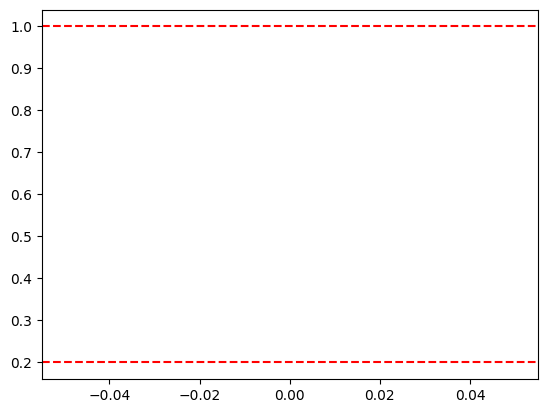

In [9]:
fig, ax = plt.subplots()
sns.stripplot(soma_depth_data, x='species', y='depth_in_layer_norm')
lower_thresh = 0.2
upper_thresh = 1
plt.axhline(lower_thresh, linestyle='--', c='r')
plt.axhline(upper_thresh, linestyle='--', c='r')


In [8]:
soma_depth_data = soma_depth_data[(soma_depth_data.depth_in_layer_norm > lower_thresh) & (soma_depth_data.depth_in_layer_norm < upper_thresh)]

data = data[data.specimen_id.isin(soma_depth_data.specimen_id.tolist())]

In [9]:
data.to_csv(os.path.join(output_dir, 'data_depth_matched.csv'), index=False)

In [10]:
cluster_order = sorted(data[cluster_col].unique())
subclass_order = sorted(data[subclass_col].unique())

Cluster box plots

In [11]:
# stats

# subclass x feature stats
x_var = cluster_col #what to do box plots on 
x_var_order = cluster_order
features = data.columns[4:].tolist()

# Mann-Whitney U test on all features
# mn_pvals = dict()
mn_pvals = {f: {} for f in features}  # Dictionary to store p-values per feature and subclass pair
for f in features:
    for var in x_var_order: 
        group_human = data.loc[(data[x_var] == var) & (data.species == 'human')][f]
        group_nhp = data.loc[(data[x_var] == var) & (data.species == 'macaque')][f]
        try:
            stats, pvalue = mannwhitneyu(group_human, group_nhp, nan_policy='omit')
            mn_pvals[f][var] = pvalue
        except: 
            print('couldn\'t compute stats for {}, perhaps because only one species has values.'.format(f))

# FDR correction for each feature's p-values
mn_pvals_fdr = {} 
mn_pvals_rejected = {} 
for f in features:
    pvals_list = list(mn_pvals[f].values())  # Get p-values for the current feature across all subclass pairs
    rejected, pvals_fdr = fdrcorrection(pvals_list, alpha=0.05, method='indep', is_sorted=False)
    mn_pvals_fdr[f] = dict(zip(mn_pvals[f].keys(), pvals_fdr))  # Store FDR corrected p-values
    mn_pvals_rejected[f] = dict(zip(mn_pvals[f].keys(), rejected))  # Store whether the hypothesis is rejected


In [12]:
box_width = 0.7
figsize = (3, 5)
compartment='dend'
species_colors = {
    'human' : '#f86586',
    'macaque' : '#65a2f8'
}

soma_surface_area | L2/3 IT_1
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_1_human vs. L2/3 IT_1_macaque: Custom statistical test, P_val:2.533e-02
soma_aligned_dist_from_pia | L2/3 IT_1
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_1_human vs. L2/3 IT_1_macaque: Custom statistical test, P_val:1.467e-03
basal_dendrite_mean_contraction | L2/3 IT_1
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_1_human vs. L2/3 IT_1_macaque: Custom statistical test, P_val:1.816e-02
basal_dendrite_max_euclidean_distance | L2/3 IT_1
p-value annotation le

C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_21132\3963072900.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=figsize,sharex=True, gridspec_kw = {'wspace':0, 'hspace':0.1}) #gridspec_kw = {'wspace':0, 'hspace':0},


basal_dendrite_bias_y | L2/3 IT_1
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_1_human vs. L2/3 IT_1_macaque: Custom statistical test, P_val:2.149e-02
apical_dendrite_std_moments_along_max_distance_projection | L2/3 IT_1
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_1_human vs. L2/3 IT_1_macaque: Custom statistical test, P_val:4.063e-02
apical_dendrite_num_outer_bifurcations | L2/3 IT_1
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_1_human vs. L2/3 IT_1_macaque: Custom statistical test, P_val:1.491e-03
apical_dendrite_mean_moments_

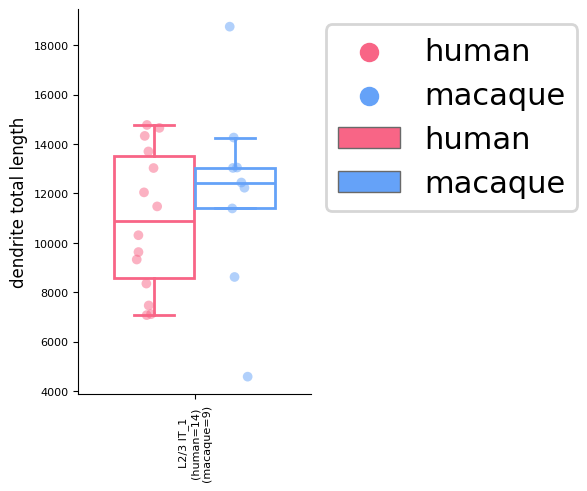

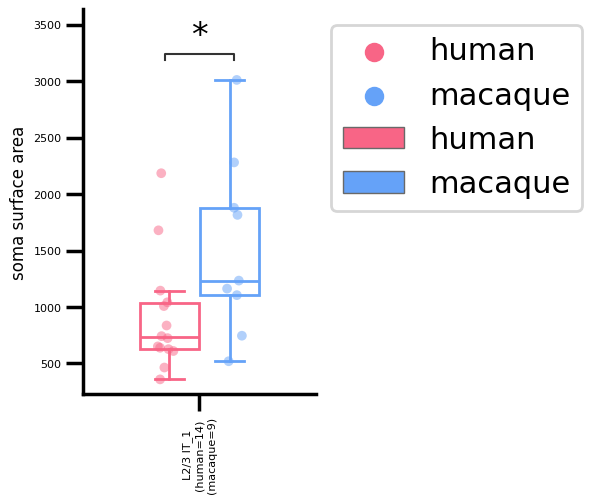

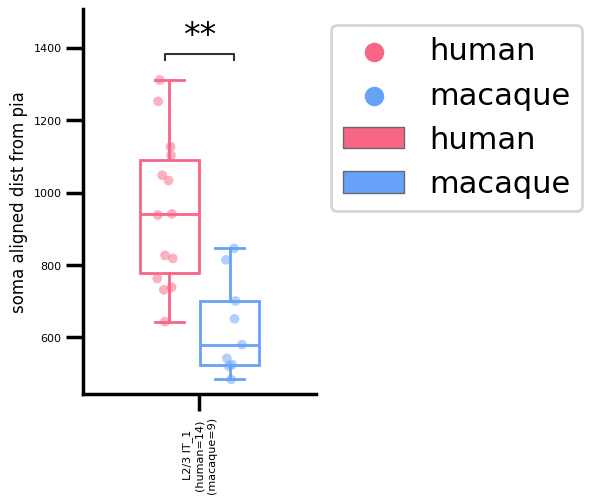

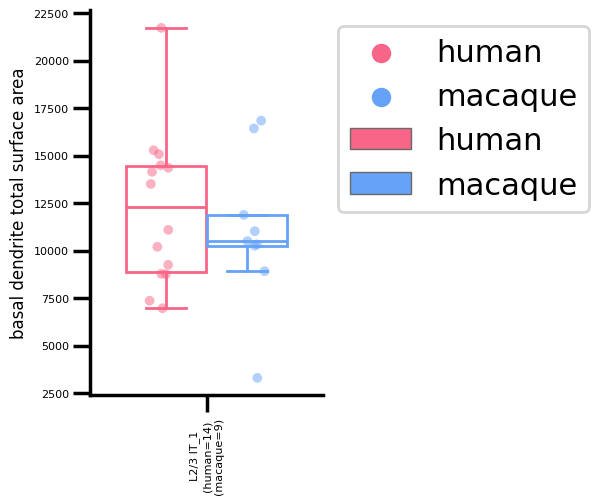

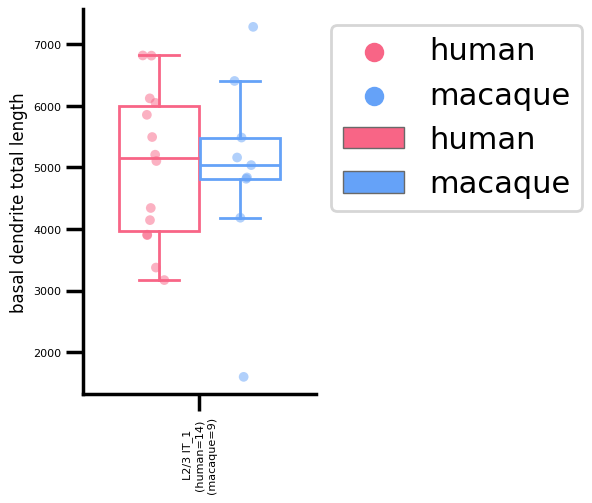

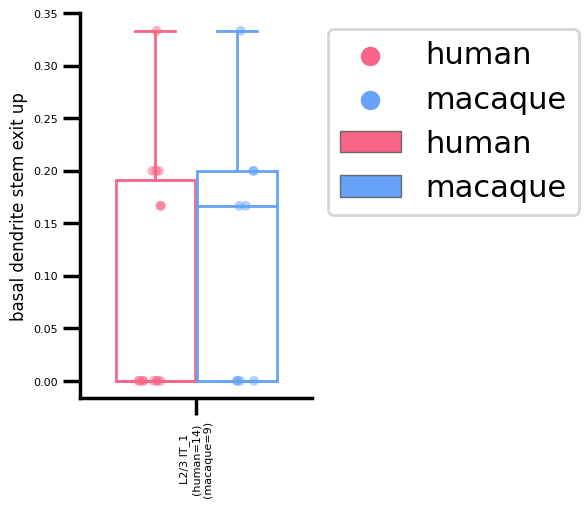

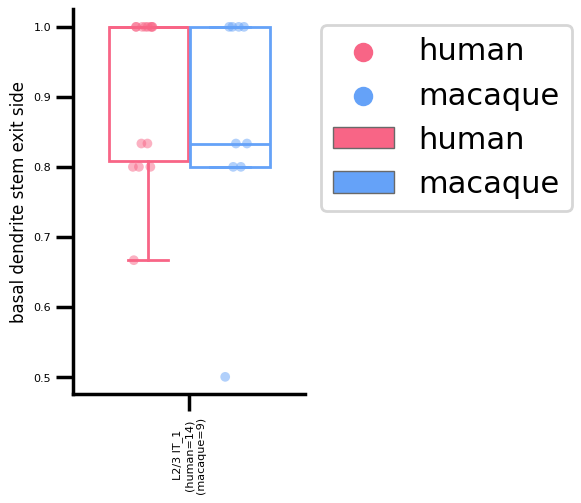

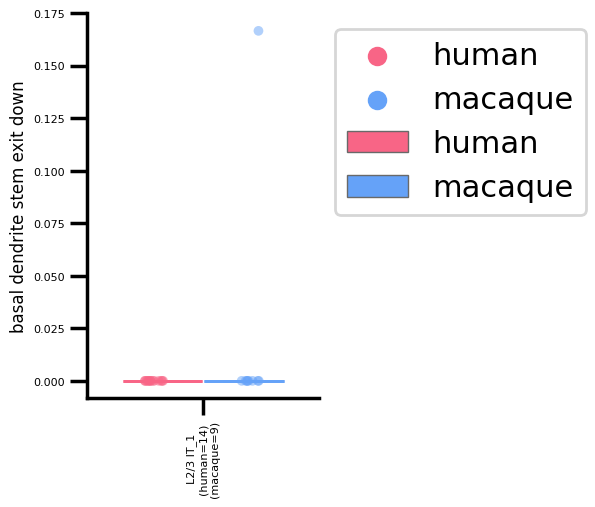

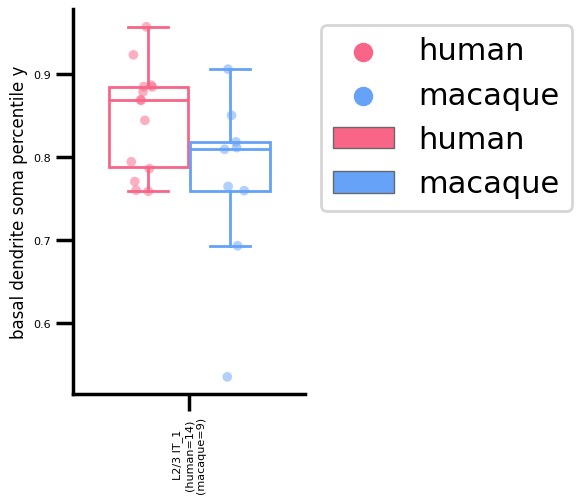

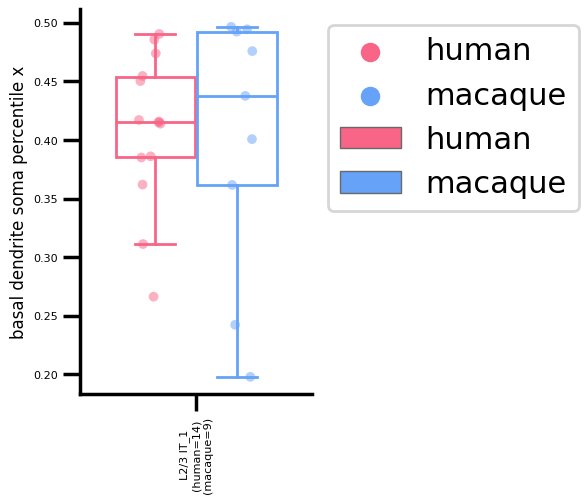

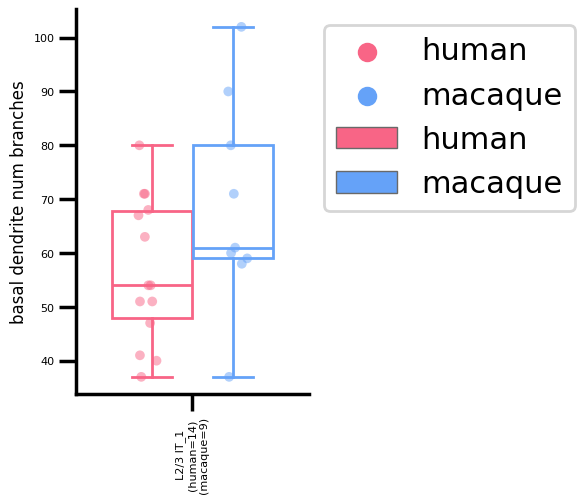

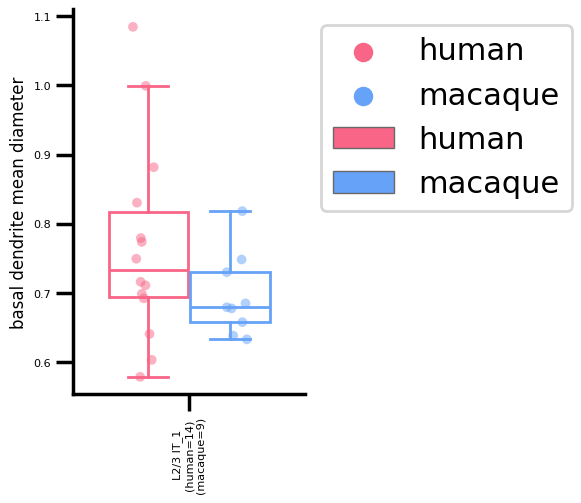

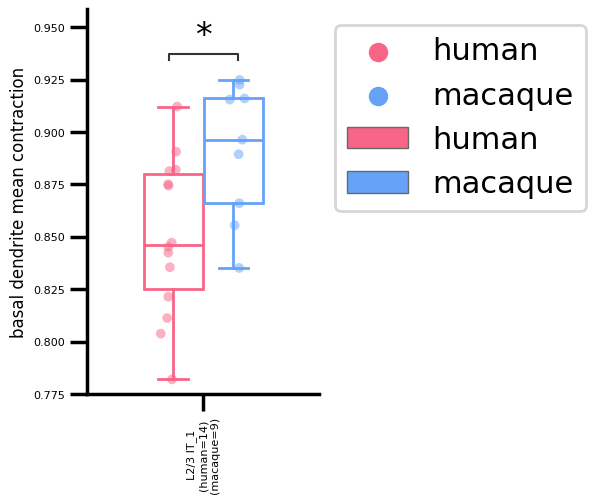

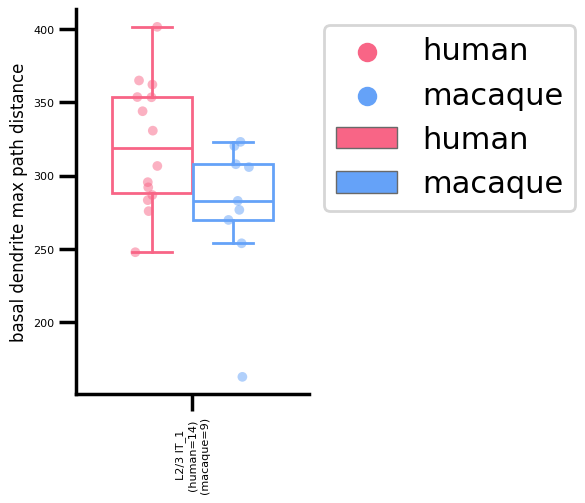

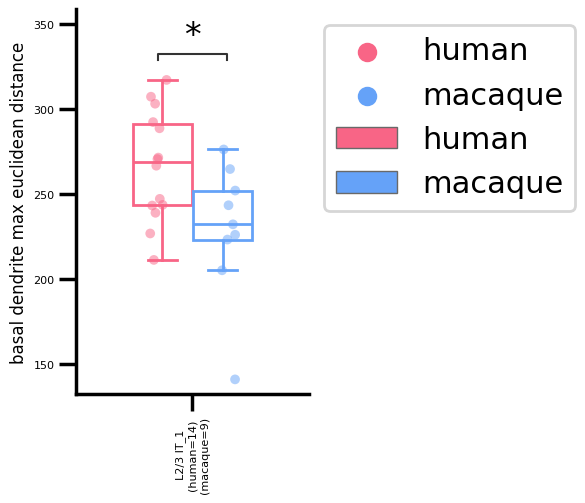

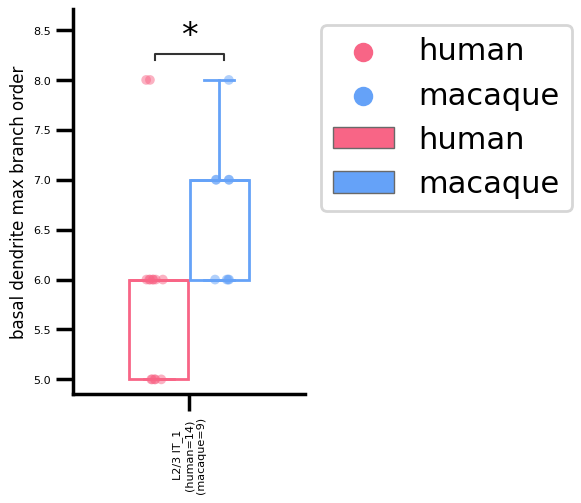

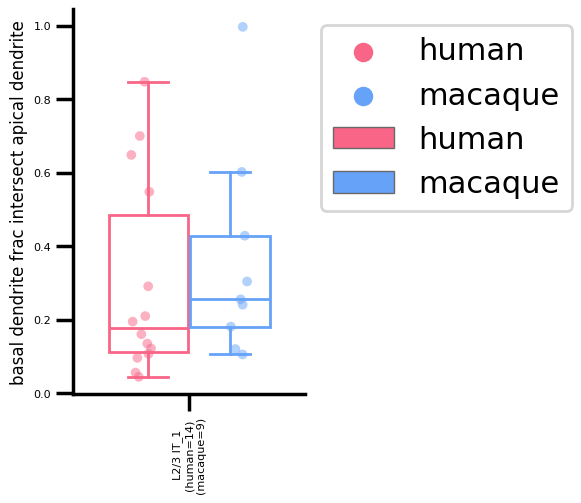

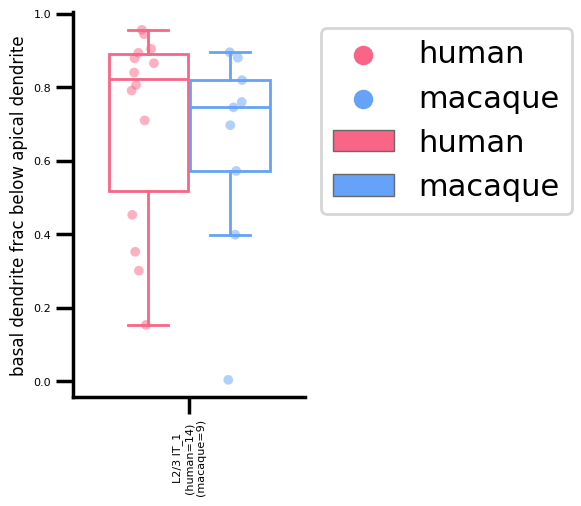

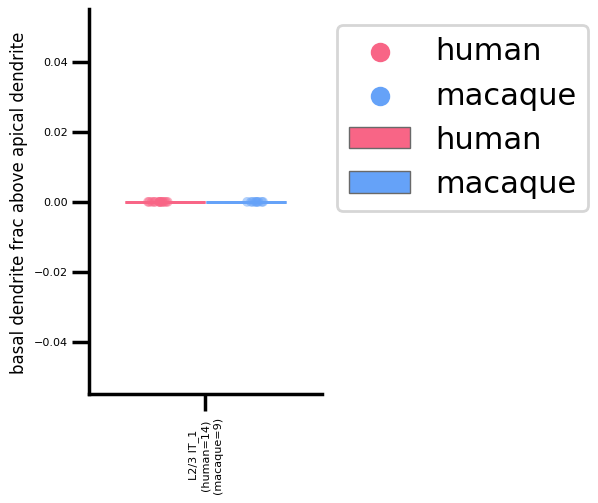

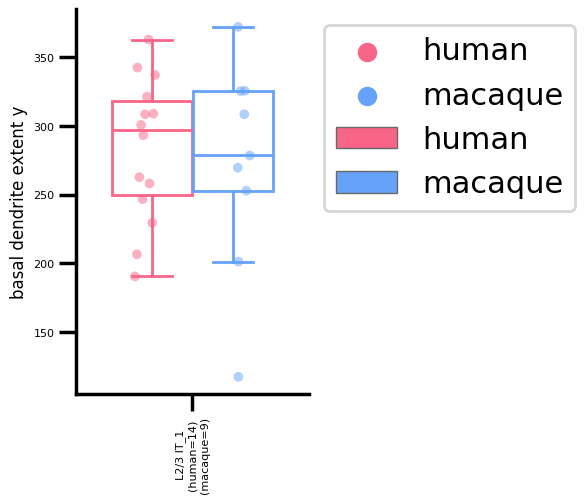

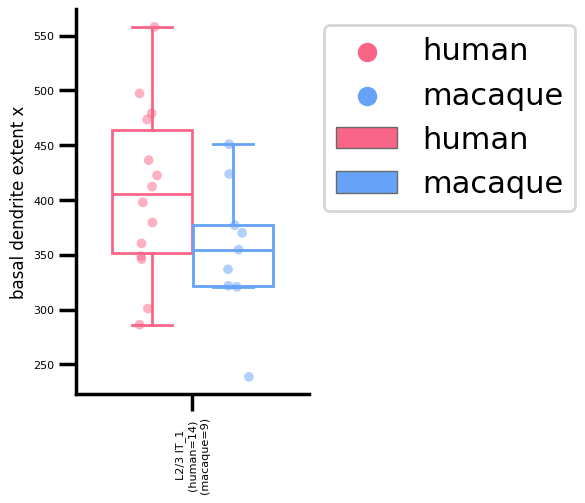

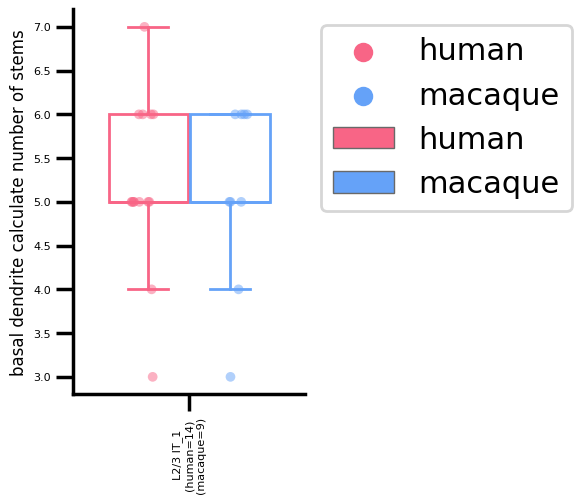

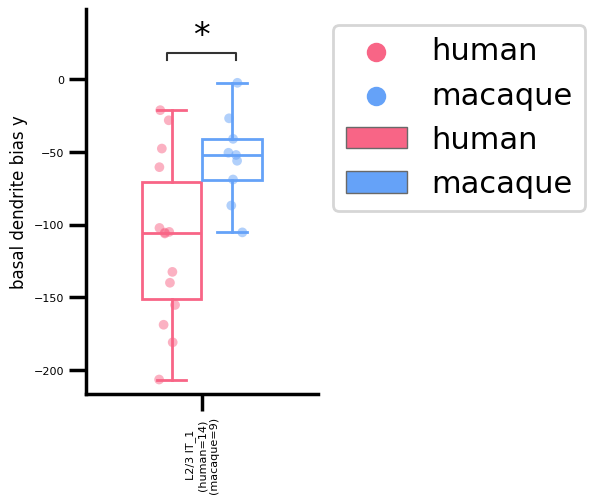

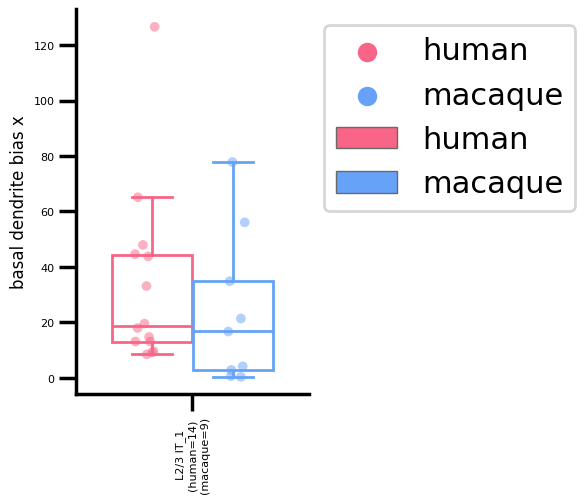

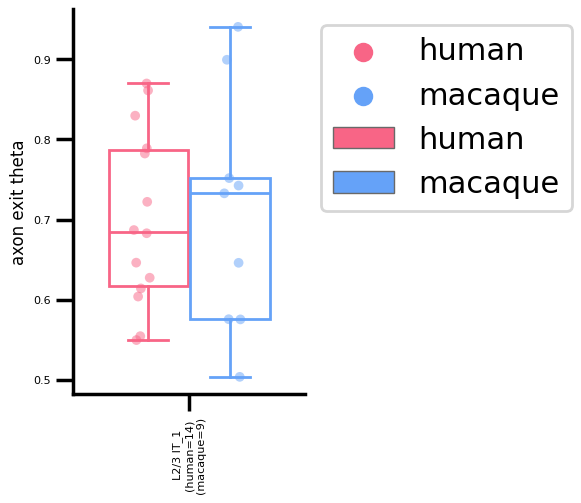

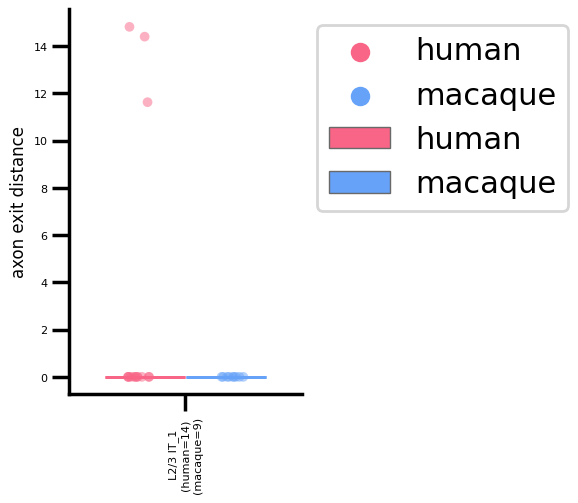

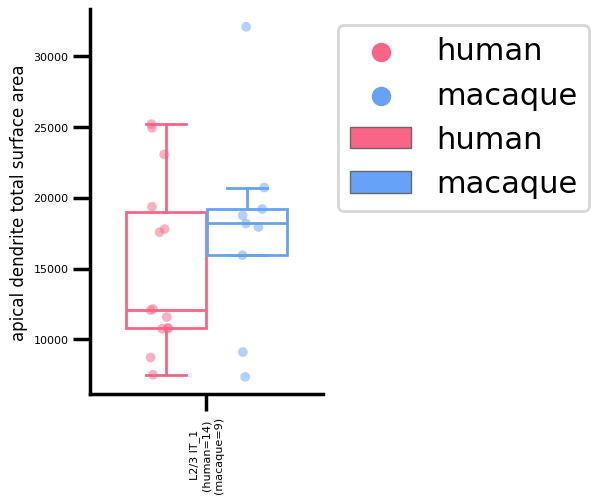

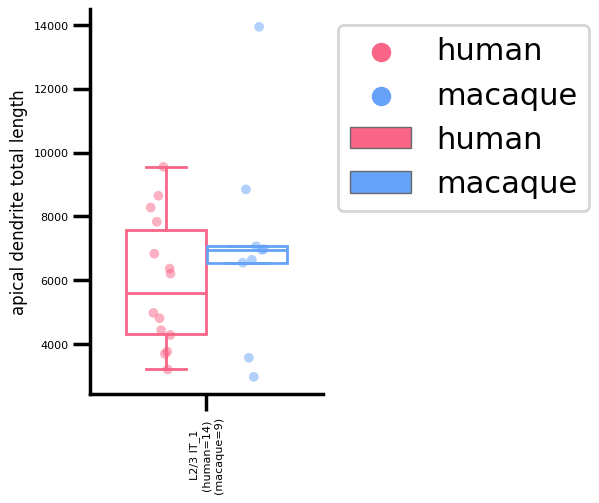

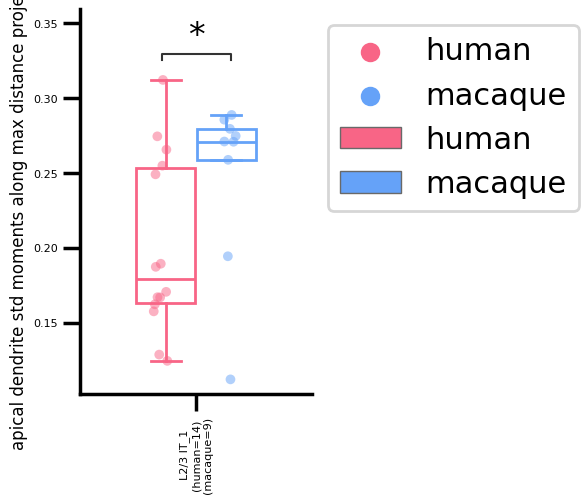

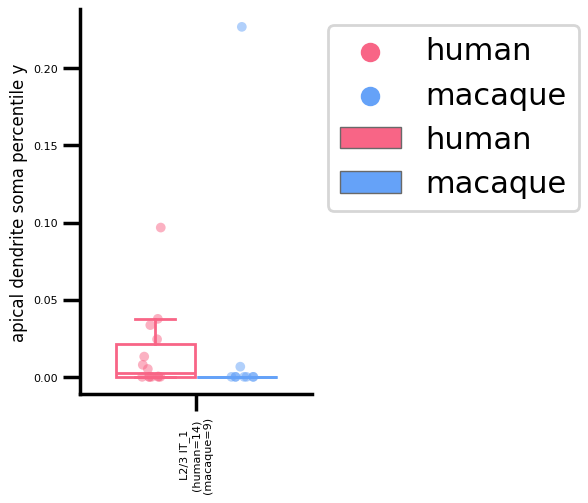

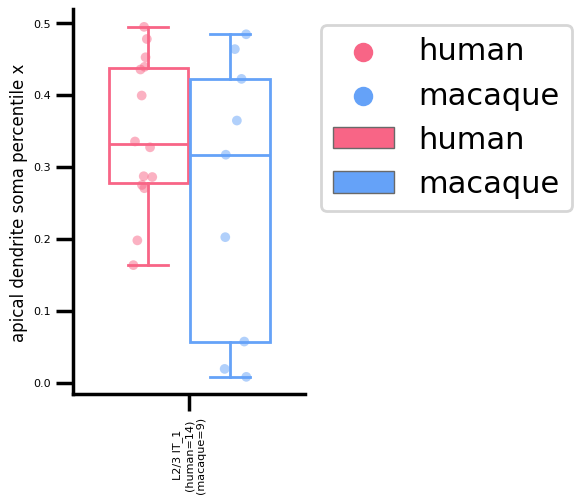

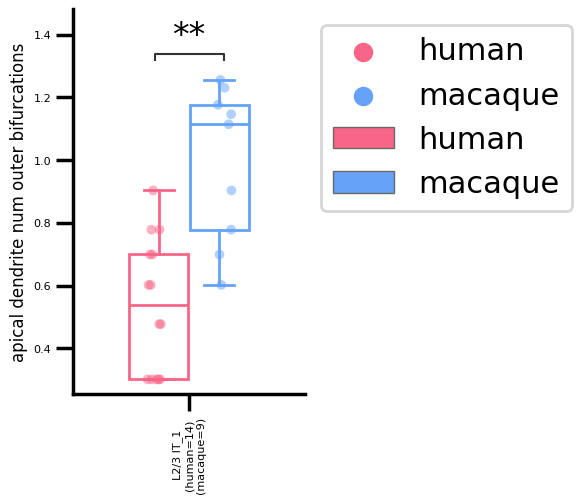

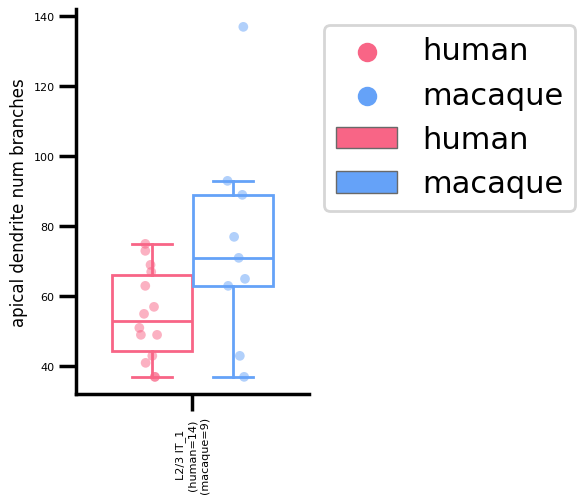

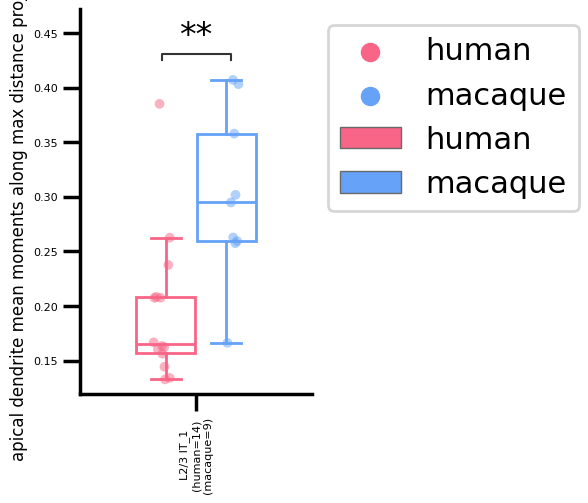

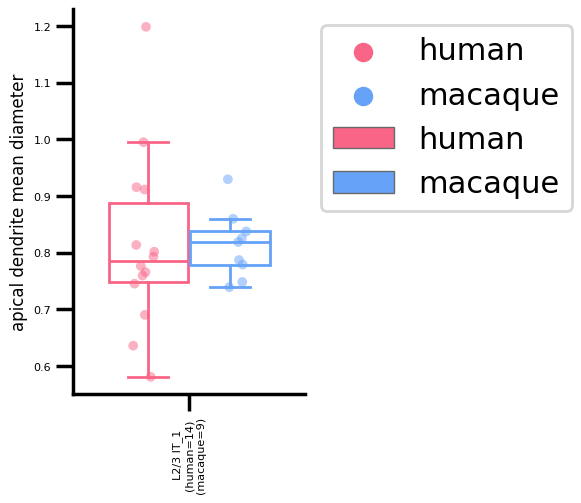

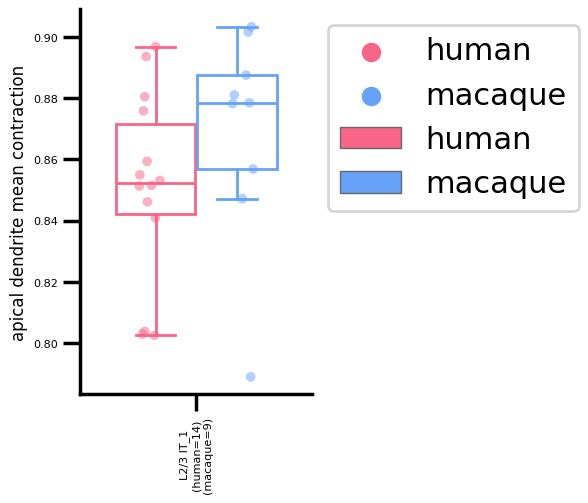

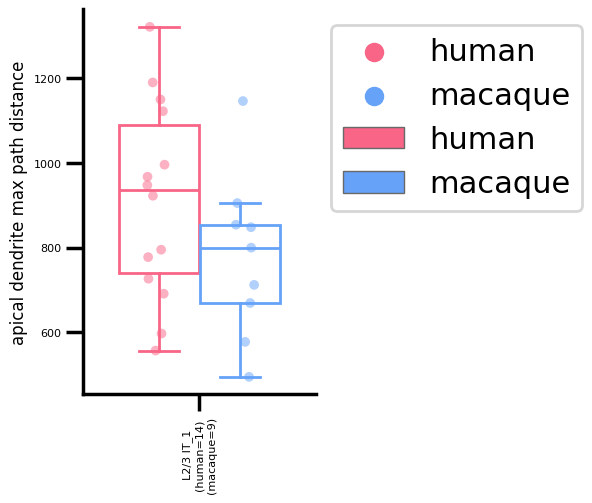

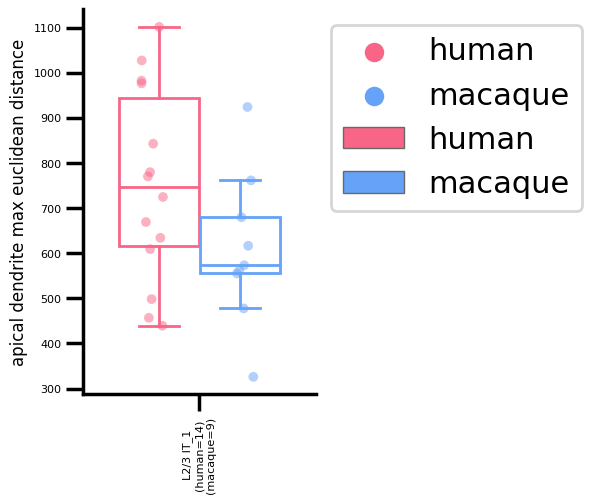

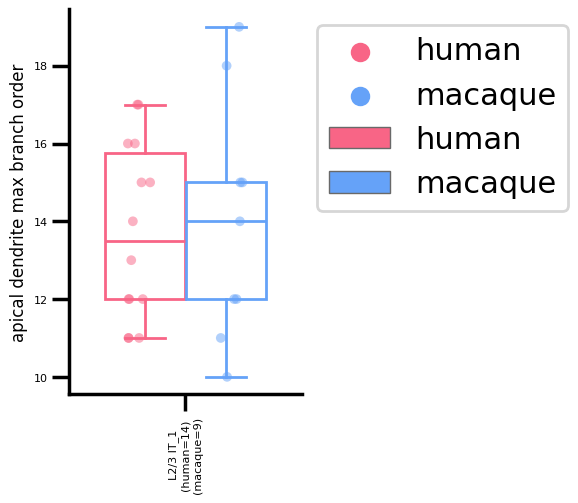

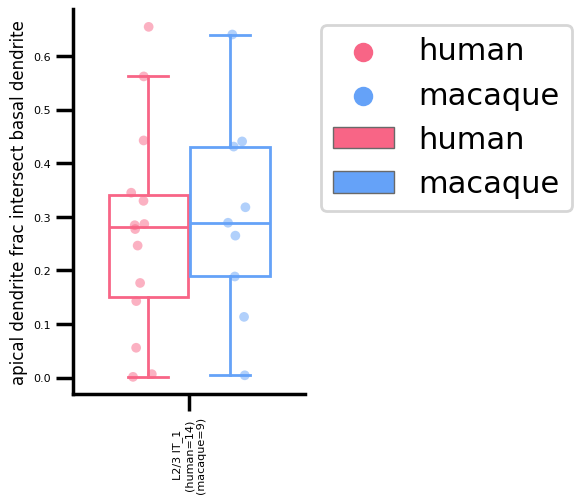

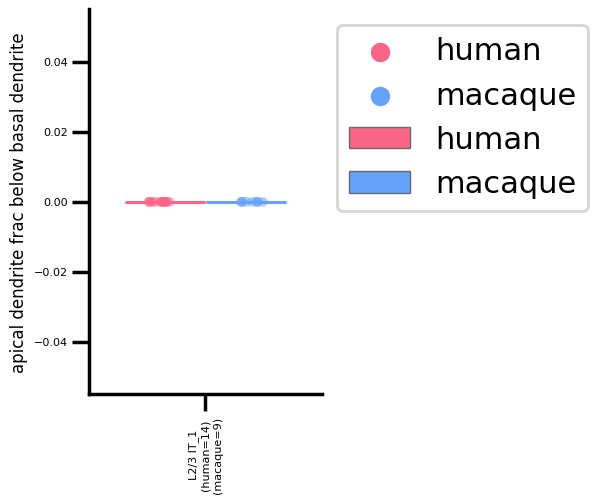

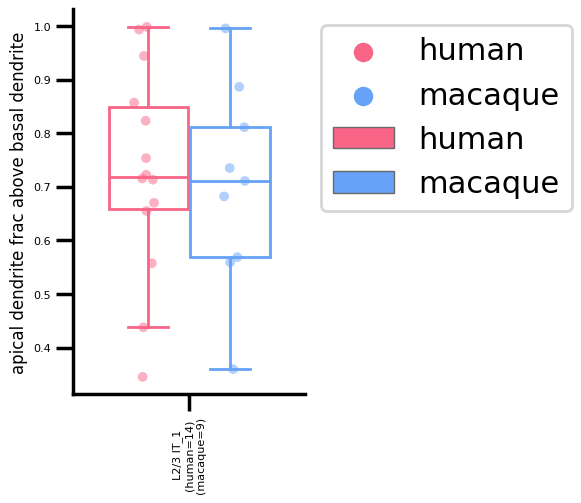

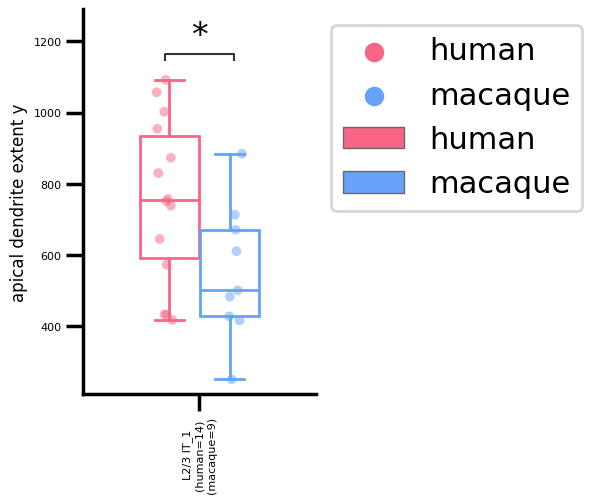

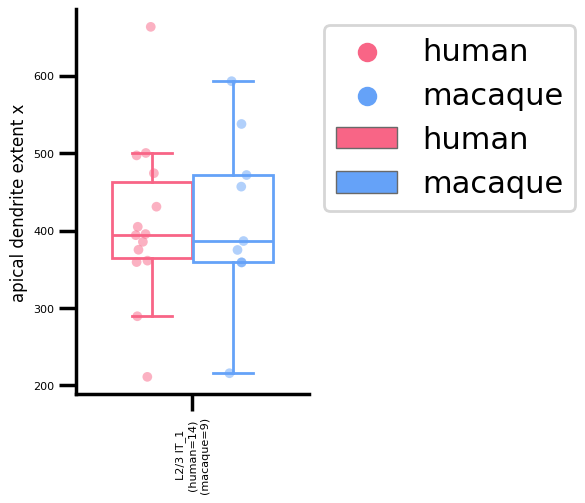

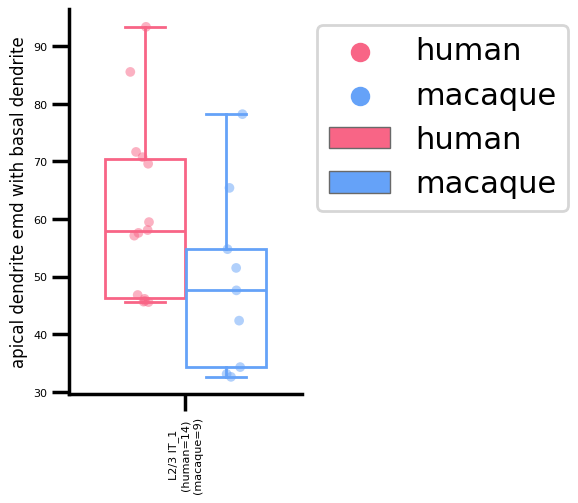

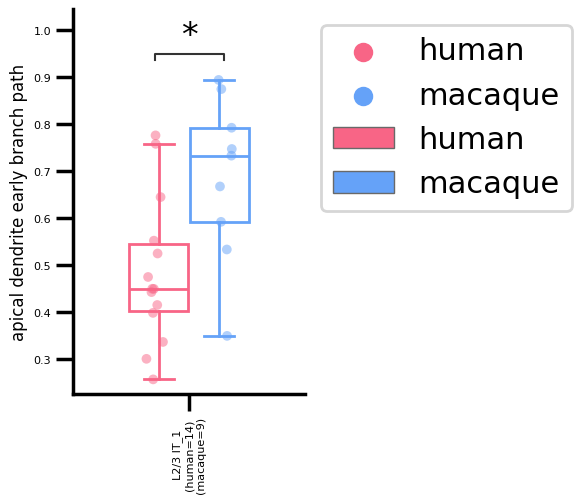

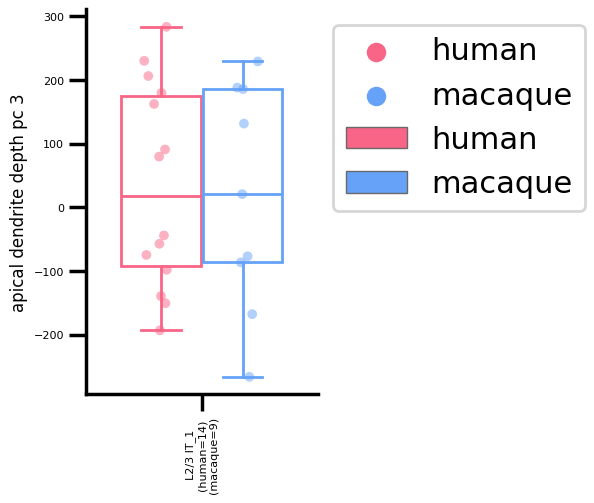

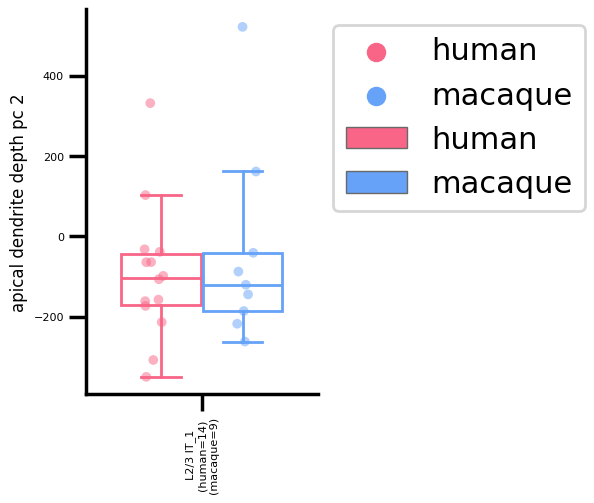

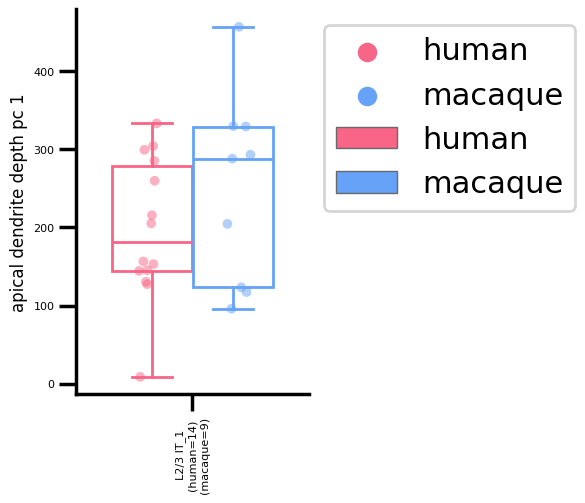

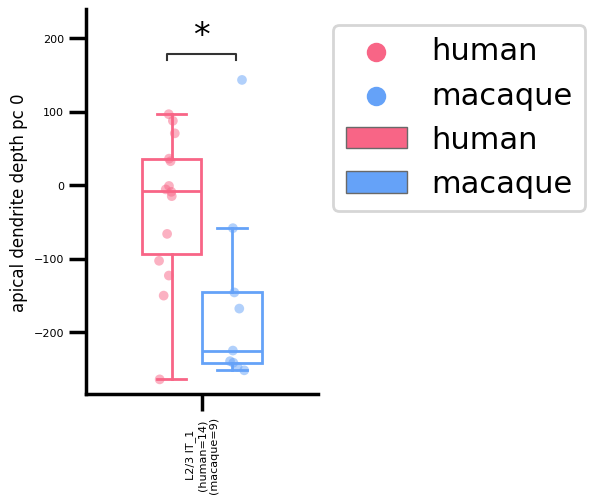

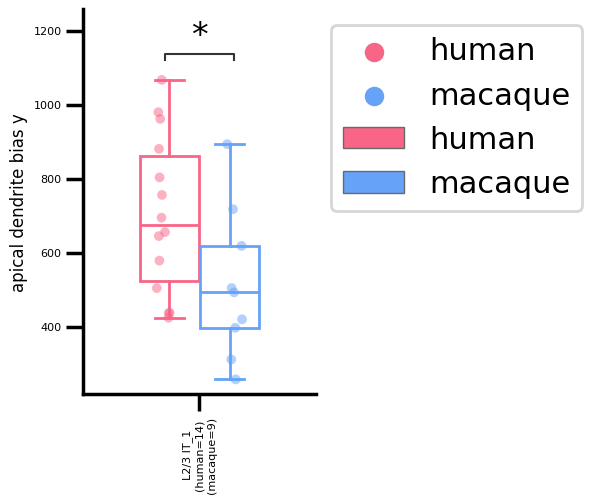

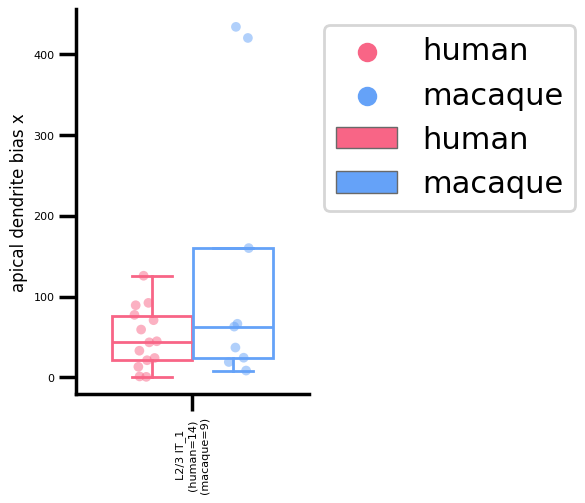

<Figure size 640x480 with 0 Axes>

In [ ]:
fig_name = f'macaque_vs_human_feature_box_plots_cluster_depth_matched.pdf'
fig_path = os.path.join(output_dir, fig_name)


features = data.columns[4:].tolist()

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    with PdfPages(fig_path) as pdf:
        while features != []:
            
            fig, ax = plt.subplots(nrows=1,ncols=1,figsize=figsize,sharex=True, gridspec_kw = {'wspace':0, 'hspace':0.1}) #gridspec_kw = {'wspace':0, 'hspace':0},
            
            #grab a feature
            y_var = features.pop()

            #plot
            sns.set_context('poster')
            sns.stripplot(data=data, x=x_var, y=y_var, hue='species', palette=species_colors, order=x_var_order, alpha=0.5, dodge=True, size=7)
            sns.boxplot(data=data, x=x_var, y=y_var, hue='species', palette=species_colors, order=x_var_order, saturation=1, linewidth=2, width=box_width, showfliers = False)
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

            # format 
            format_box_plot(ax) #clear fill of box plots, color edges
            sns.despine(right=True, top=True)
            ax.set(xlabel=None)
            ax.set_ylabel(y_var.replace("_", " "), rotation=90, size=12)
            ax.tick_params(axis='x', rotation=90, labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

            #add num observations per x_var
            nobs = []
            for t in x_var_order:
                np = len(data[(data[x_var] == t) & (data.species == 'macaque')])
                nh = len(data[(data[x_var] == t) & (data.species == 'human')])
                nobs.append(f"{t}\n(human={nh})\n(macaque={np})")
            new_x_tick_labels = [nobs[i] for i in range(len(x_var_order))]  
            ax.set_xticklabels(new_x_tick_labels)

            #add stats (Mann-Whitney U test FDR corrected)
            if y_var in mn_pvals_fdr.keys():
                #stats were computed for this feature
                pairs = []
                p_values = []
                for subclass_var in mn_pvals_rejected[y_var].keys():
                    if mn_pvals_rejected[y_var][subclass_var]:
                        print(f'{y_var} | {subclass_var}')
                        #signif diff btw human and nhp for this subclass pair
                        pairs.append([(subclass_var, 'human'), (subclass_var, 'macaque')])
                        p_values.append(mn_pvals_fdr[y_var][subclass_var])

                if len(pairs): 
                    #there's at least one pair of x_vals for which fdr corrected dunn test is signif
                    annotator = Annotator(ax, pairs, data=data, x=x_var, y=y_var, hue='species', order=x_var_order)
                    annotator.configure(text_format="star", loc="inside") #text_format="simple"
                    annotator.set_pvalues_and_annotate(p_values)

            fig.subplots_adjust(wspace=0, hspace=0.0)
            pdf.savefig(dpi=600, bbox_inches='tight')
        plt.show()
        plt.clf()
        print()




Subclass box plots

In [14]:
# stats

# subclass x feature stats
x_var = subclass_col #what to do box plots on 
x_var_order = subclass_order
features = data.columns[4:].tolist()

# Mann-Whitney U test on all features
# mn_pvals = dict()
mn_pvals = {f: {} for f in features}  # Dictionary to store p-values per feature and subclass pair
for f in features:
    for var in x_var_order: 
        group_human = data.loc[(data[x_var] == var) & (data.species == 'human')][f]
        group_nhp = data.loc[(data[x_var] == var) & (data.species == 'macaque')][f]
        try:
            stats, pvalue = mannwhitneyu(group_human, group_nhp, nan_policy='omit')
            mn_pvals[f][var] = pvalue
        except: 
            print('couldn\'t compute stats for {}, perhaps because only one species has values.'.format(f))

# FDR correction for each feature's p-values
mn_pvals_fdr = {} 
mn_pvals_rejected = {} 
for f in features:
    pvals_list = list(mn_pvals[f].values())  # Get p-values for the current feature across all subclass pairs
    rejected, pvals_fdr = fdrcorrection(pvals_list, alpha=0.05, method='indep', is_sorted=False)
    mn_pvals_fdr[f] = dict(zip(mn_pvals[f].keys(), pvals_fdr))  # Store FDR corrected p-values
    mn_pvals_rejected[f] = dict(zip(mn_pvals[f].keys(), rejected))  # Store whether the hypothesis is rejected


In [15]:
box_width = 0.7
figsize = (3, 5)
compartment='dend'
species_colors = {
    'human' : '#f86586',
    'macaque' : '#65a2f8'
}

soma_surface_area | L2/3 IT
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_human vs. L2/3 IT_macaque: Custom statistical test, P_val:2.533e-02
soma_aligned_dist_from_pia | L2/3 IT
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_human vs. L2/3 IT_macaque: Custom statistical test, P_val:1.467e-03
basal_dendrite_mean_contraction | L2/3 IT
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_human vs. L2/3 IT_macaque: Custom statistical test, P_val:1.816e-02
basal_dendrite_max_euclidean_distance | L2/3 IT
p-value annotation legend:
      ns: 5.00

C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_21132\1200694583.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=figsize,sharex=True, gridspec_kw = {'wspace':0, 'hspace':0.1}) #gridspec_kw = {'wspace':0, 'hspace':0},


basal_dendrite_bias_y | L2/3 IT
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_human vs. L2/3 IT_macaque: Custom statistical test, P_val:2.149e-02
apical_dendrite_std_moments_along_max_distance_projection | L2/3 IT
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_human vs. L2/3 IT_macaque: Custom statistical test, P_val:4.063e-02
apical_dendrite_num_outer_bifurcations | L2/3 IT
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L2/3 IT_human vs. L2/3 IT_macaque: Custom statistical test, P_val:1.491e-03
apical_dendrite_mean_moments_along_max_distance

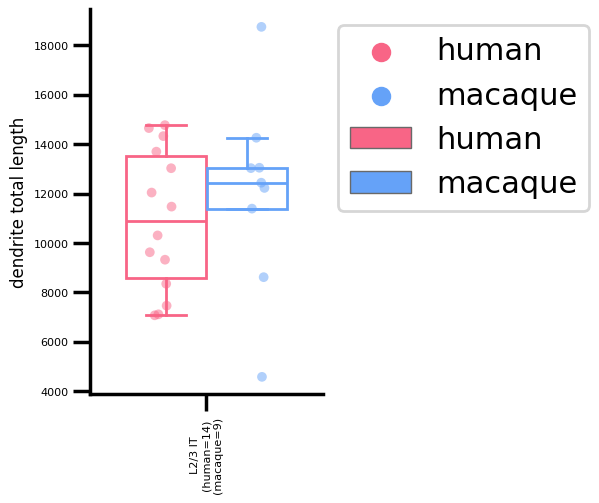

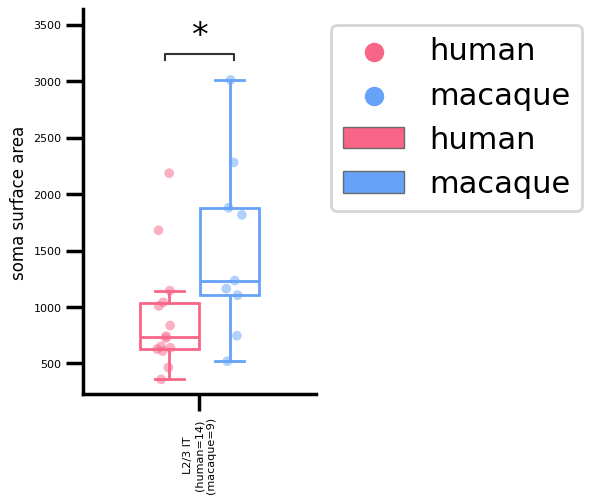

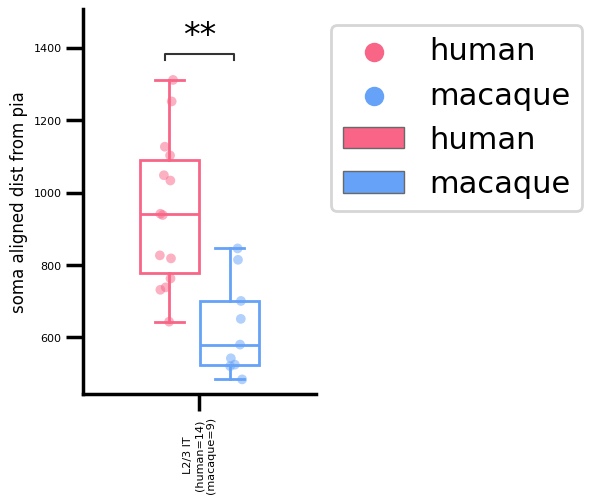

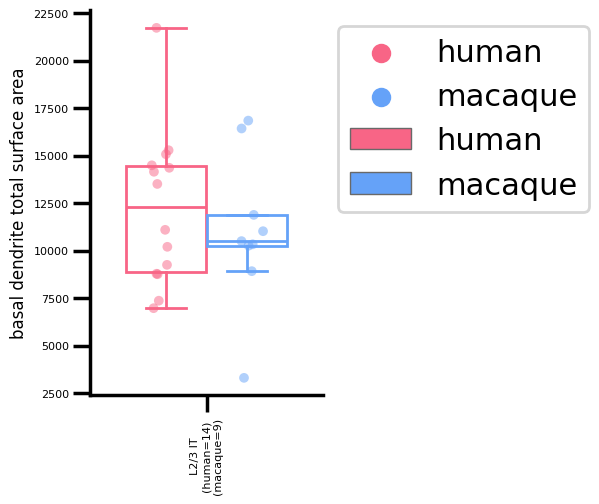

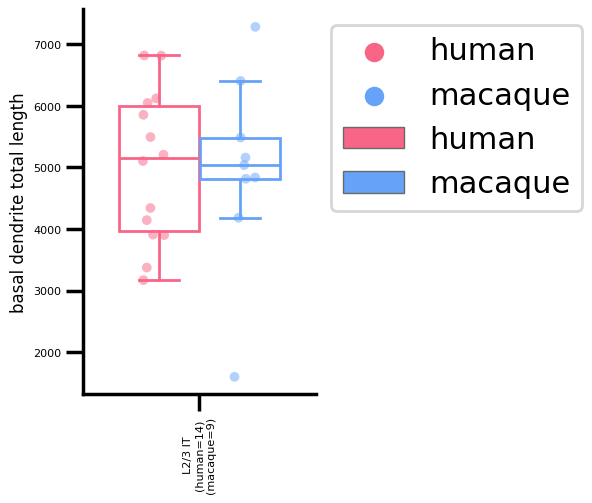

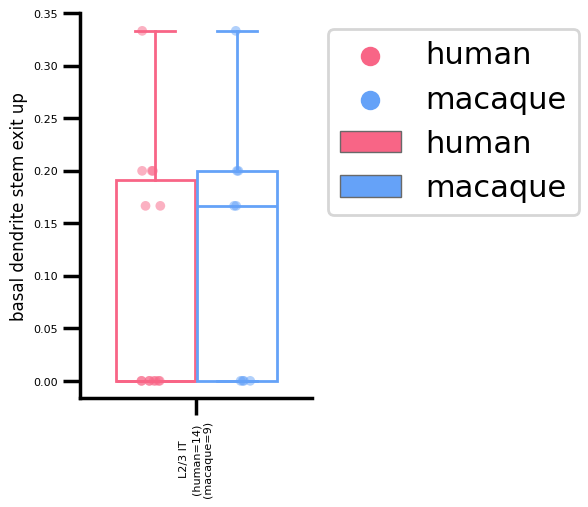

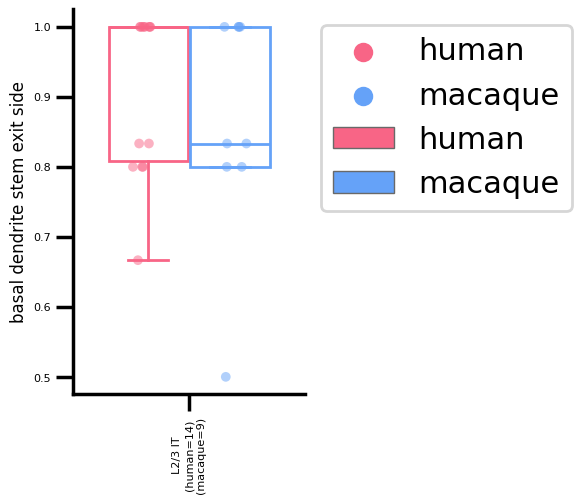

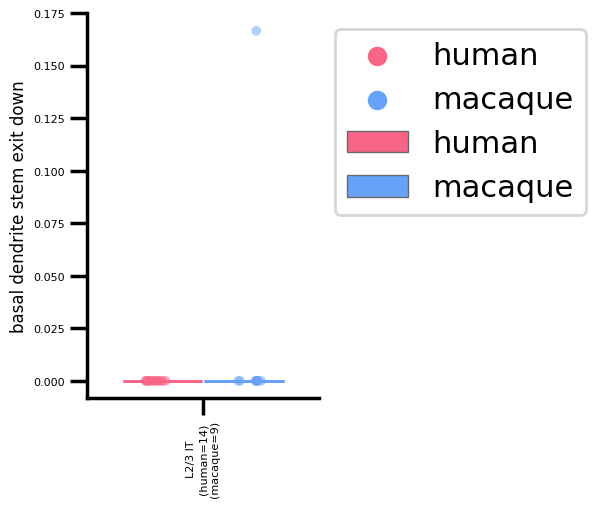

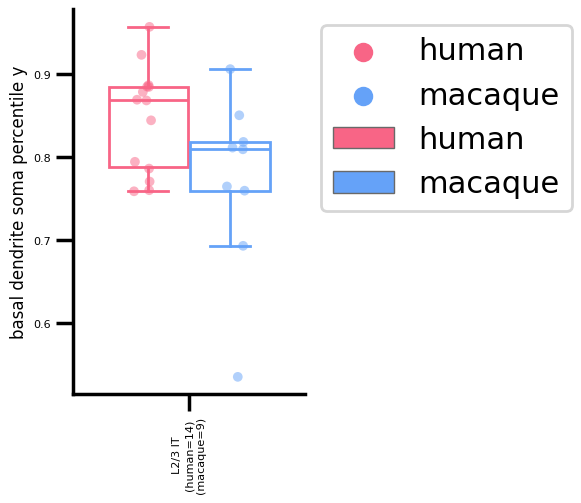

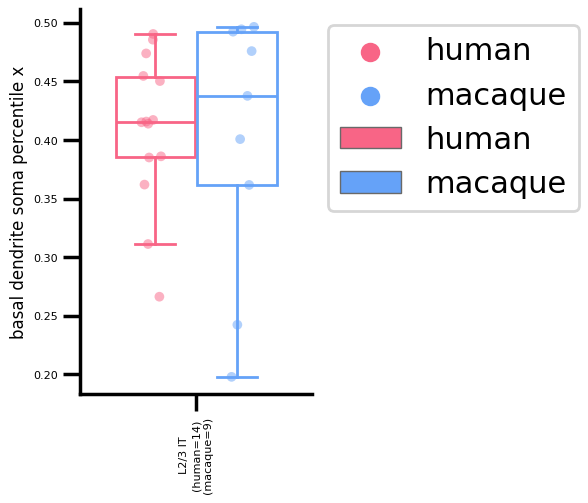

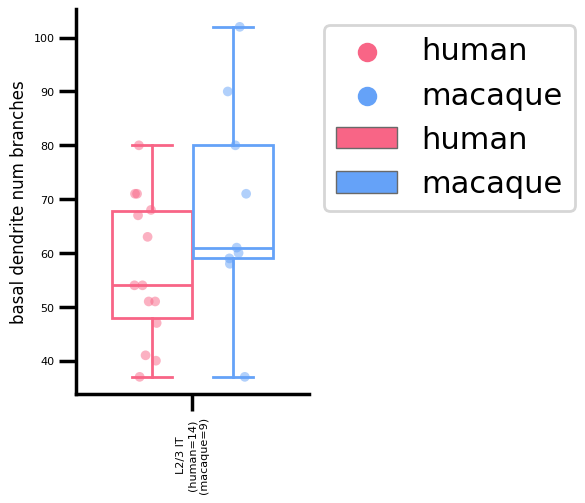

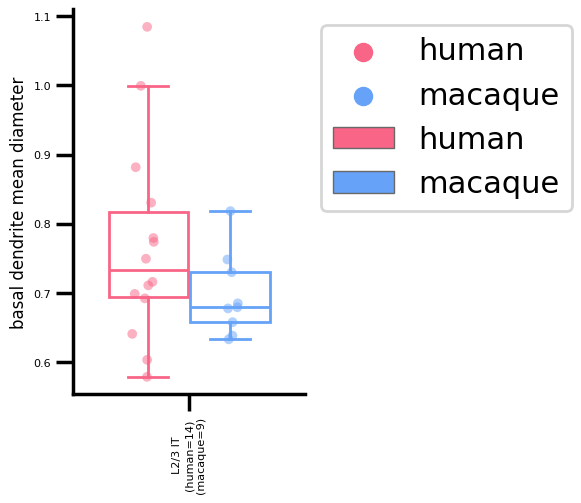

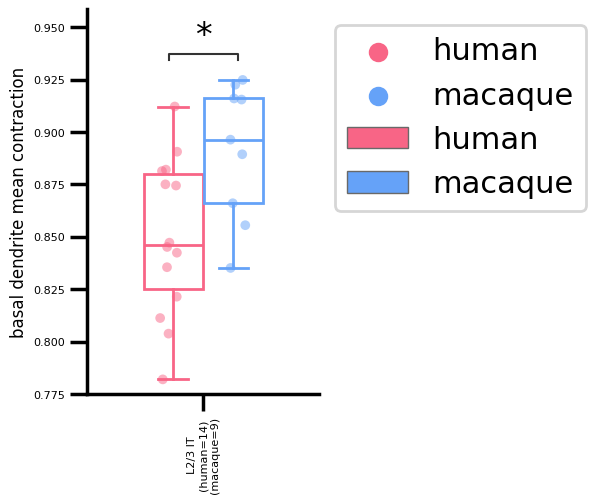

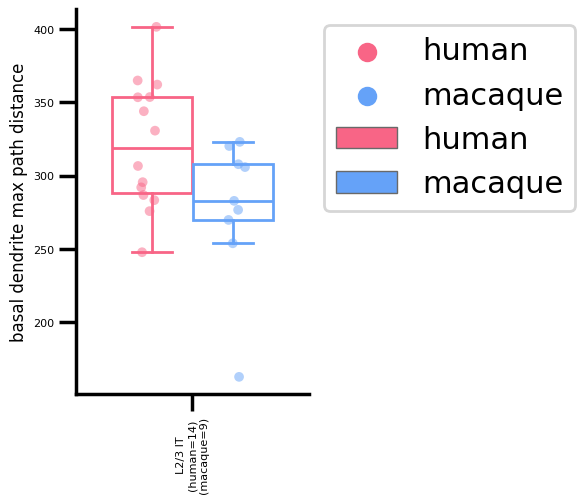

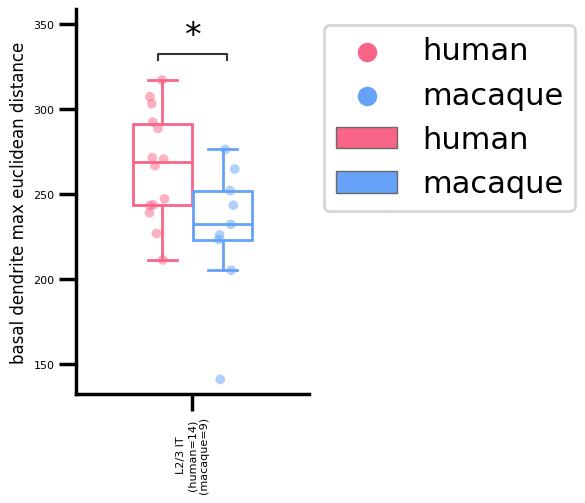

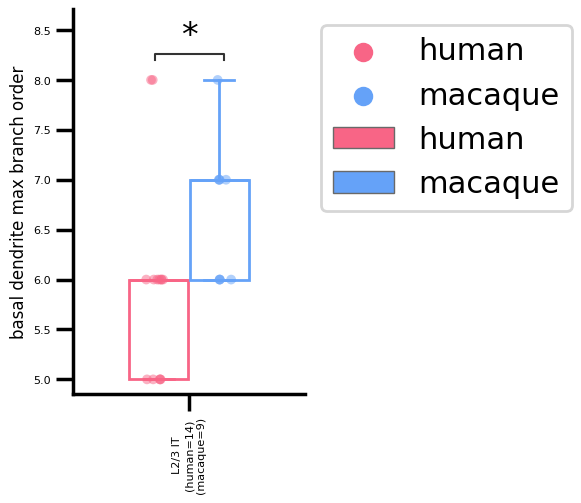

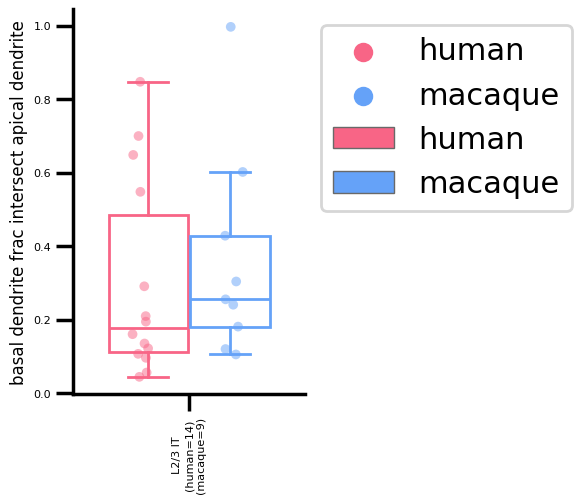

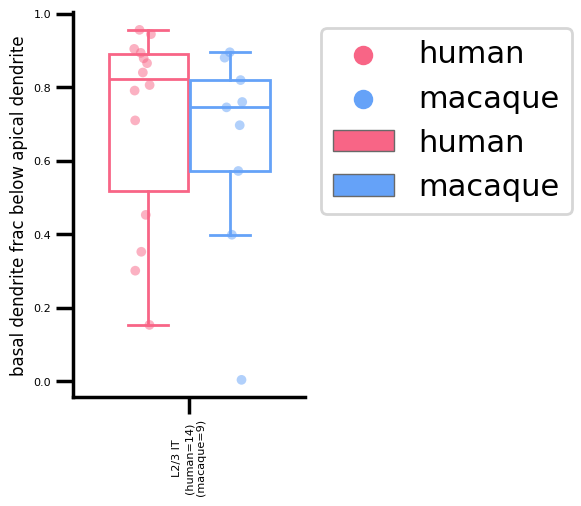

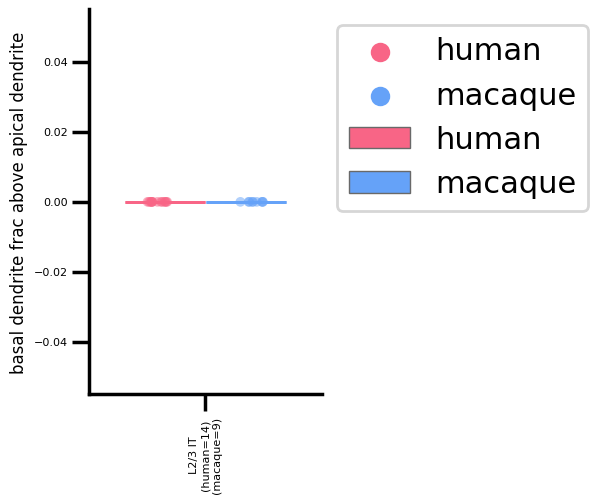

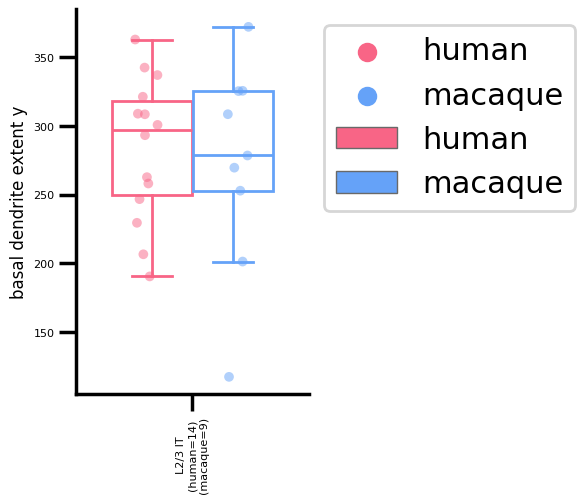

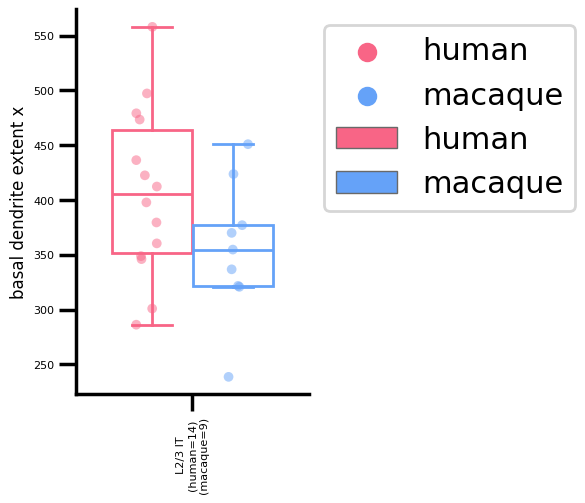

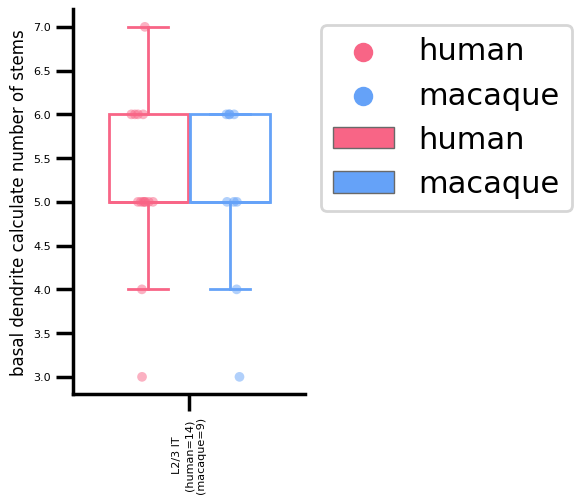

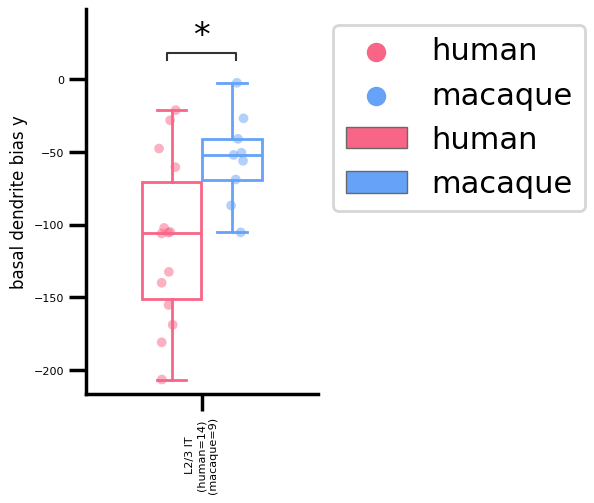

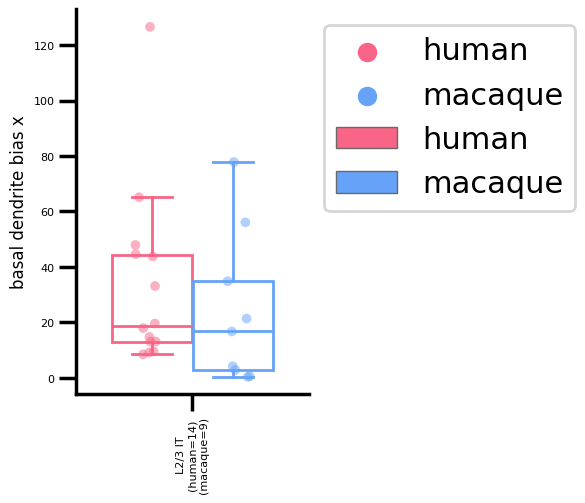

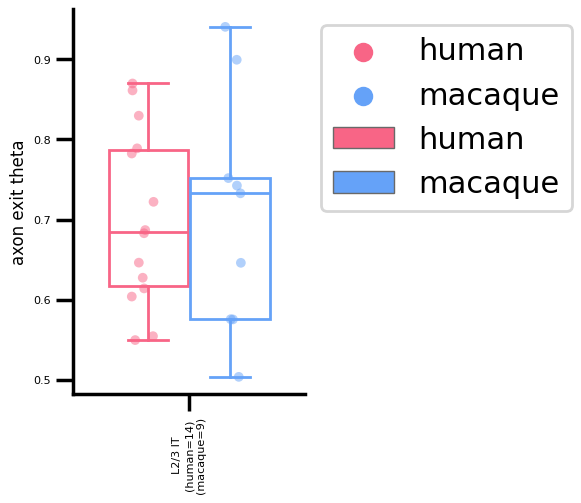

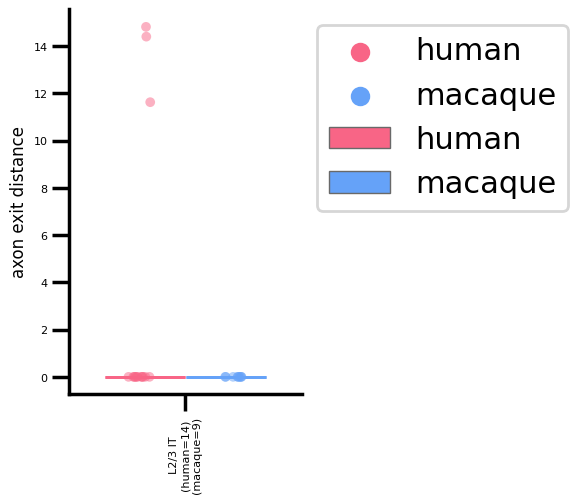

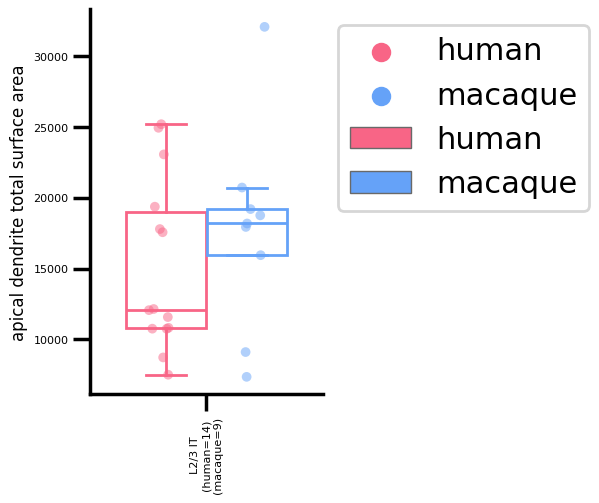

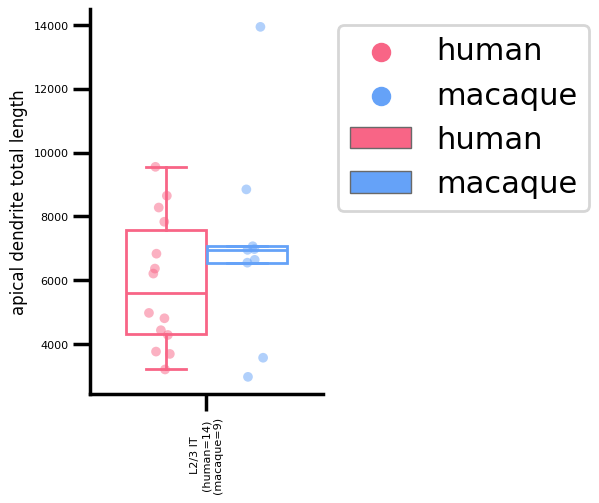

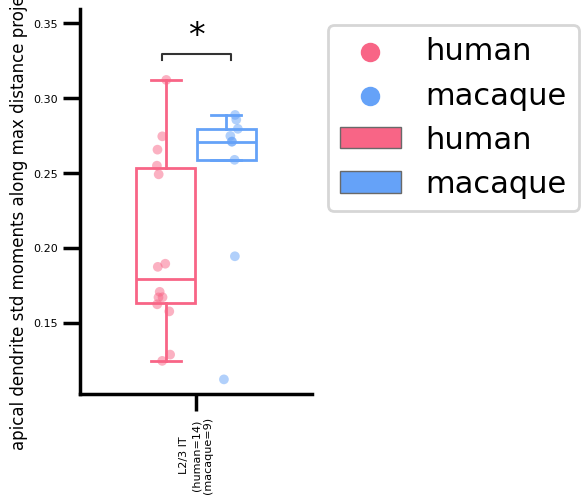

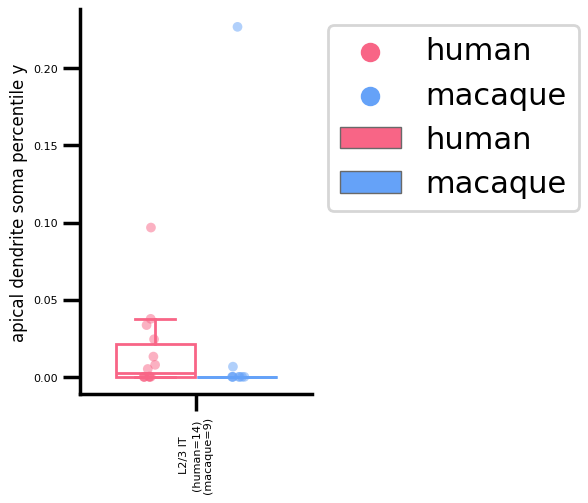

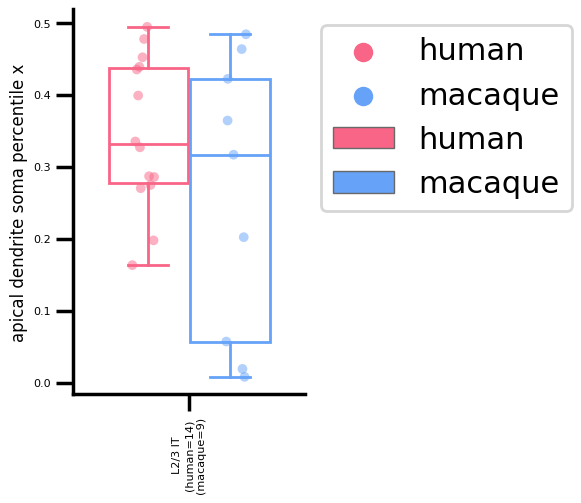

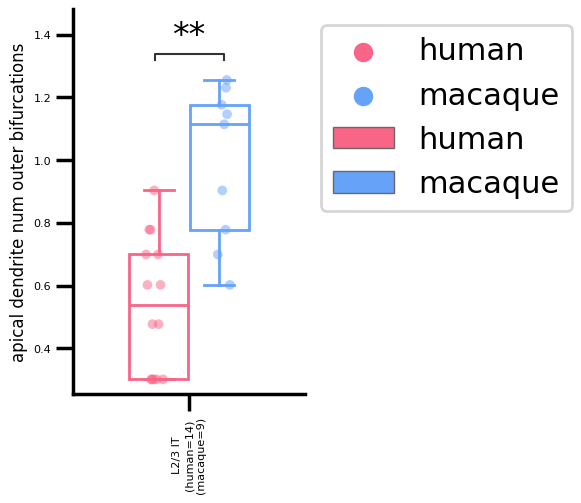

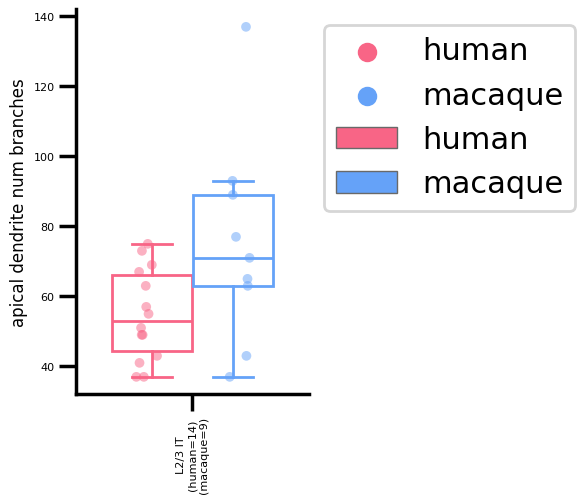

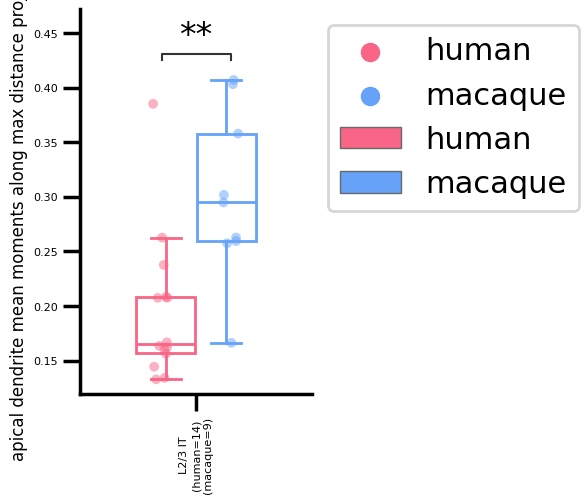

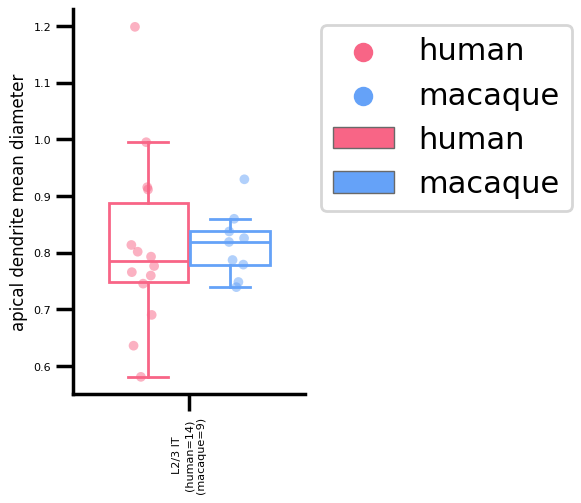

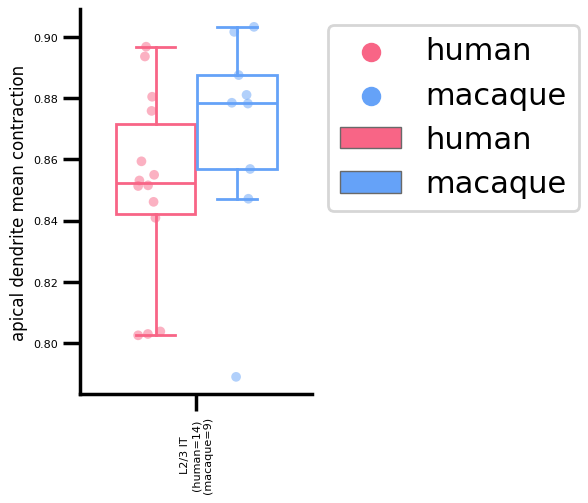

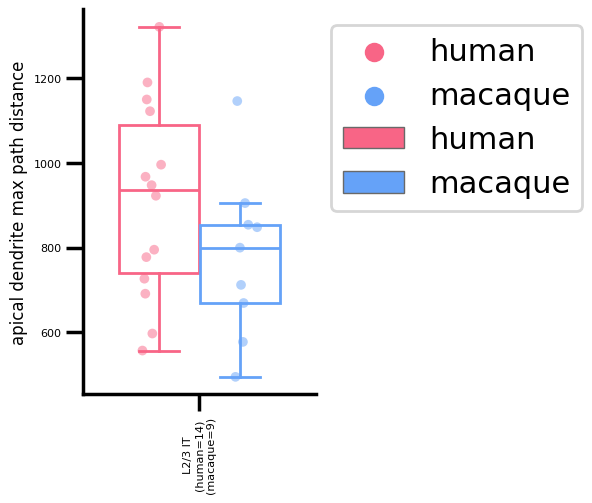

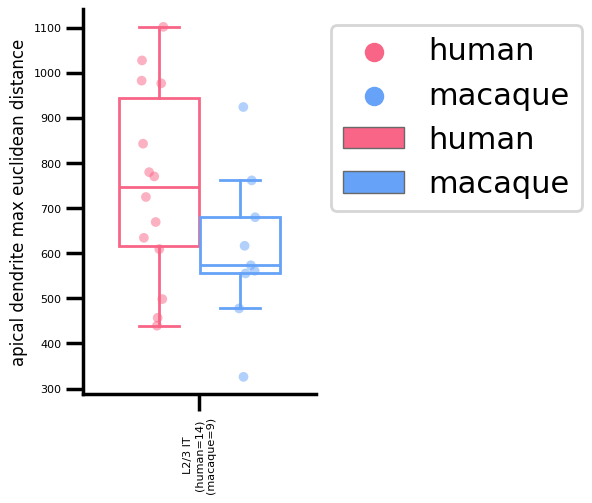

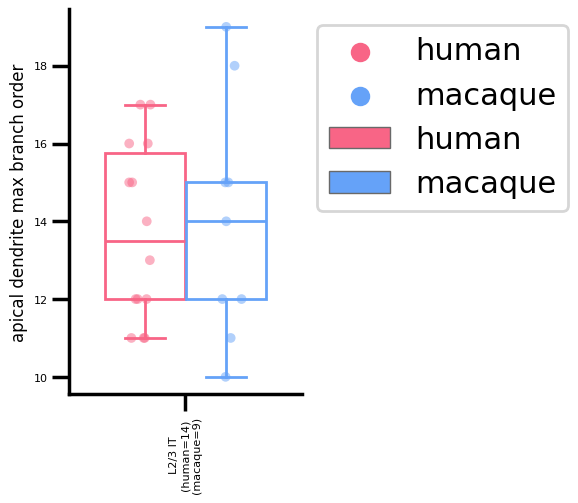

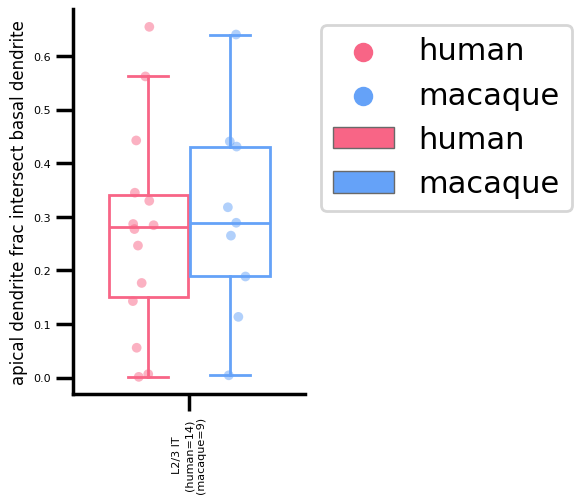

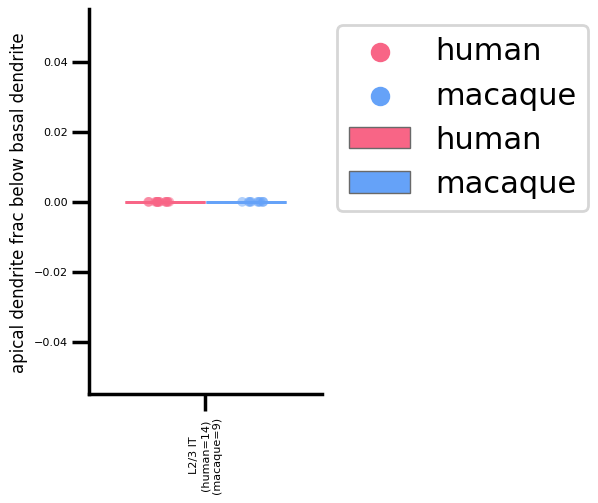

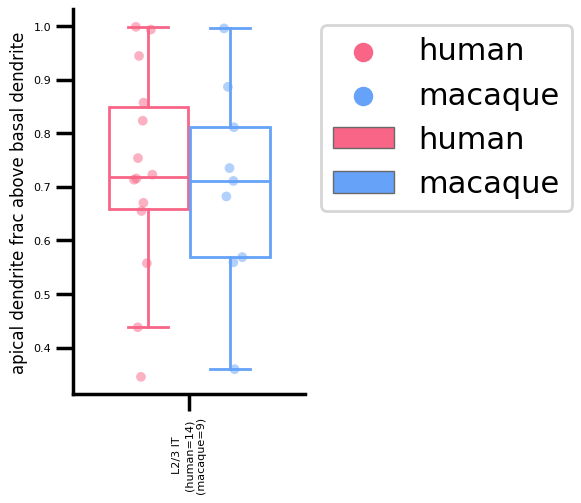

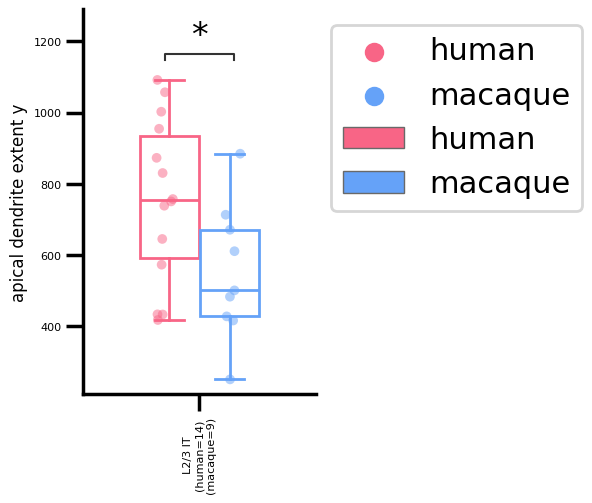

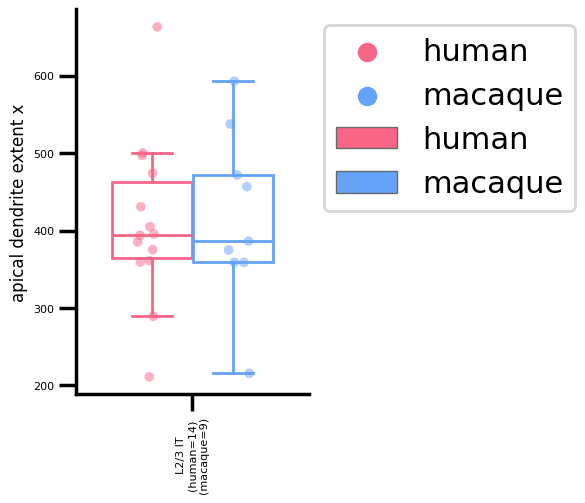

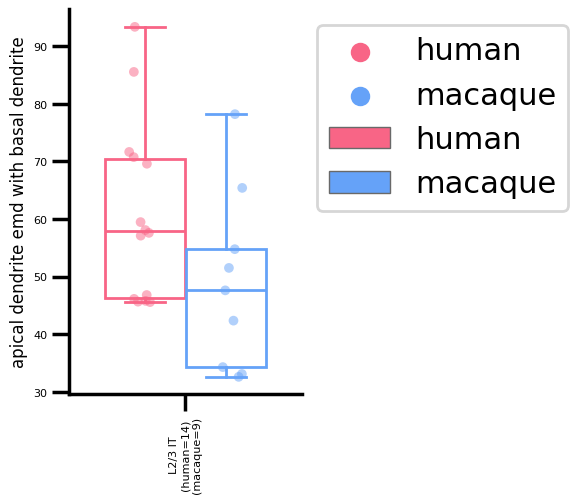

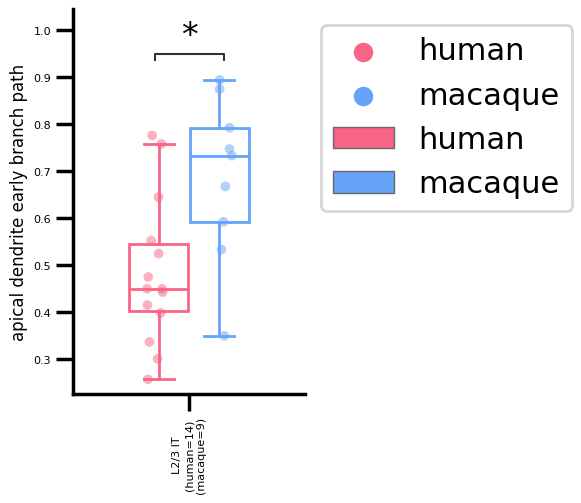

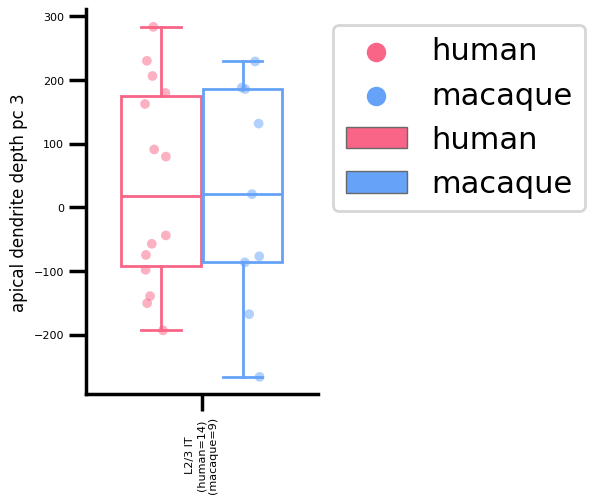

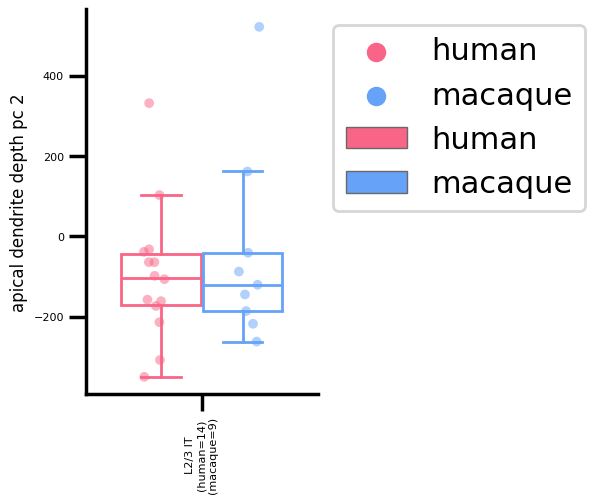

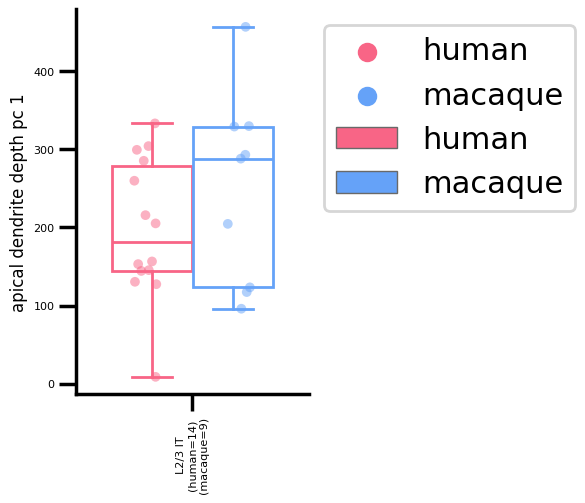

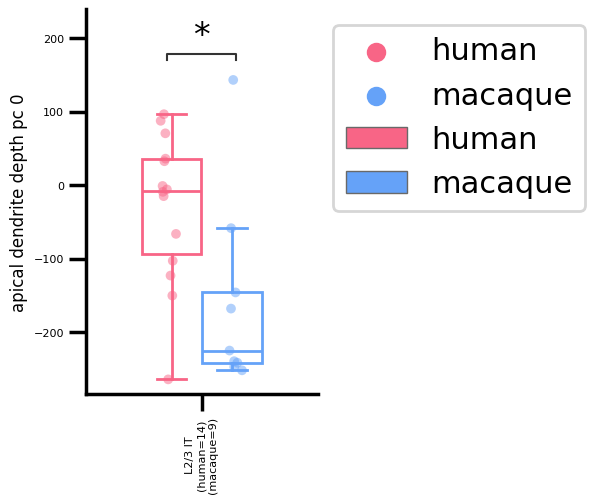

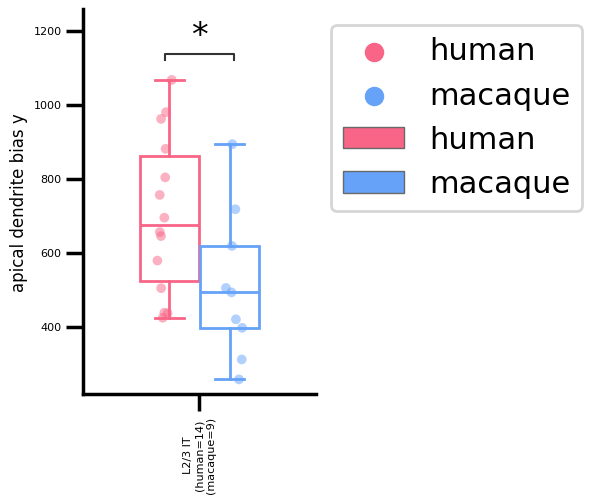

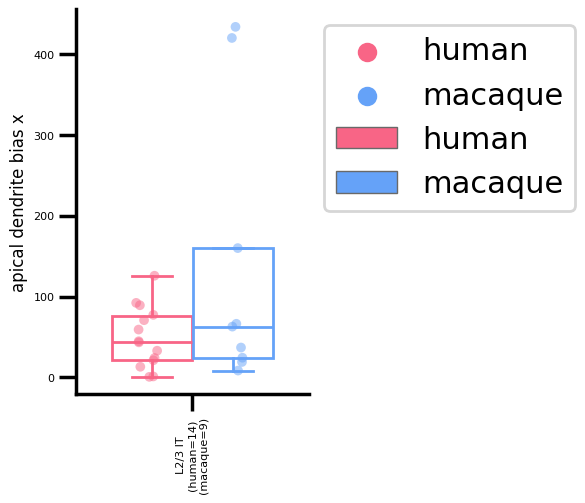

<Figure size 640x480 with 0 Axes>

In [16]:
fig_name = f'macaque_vs_human_feature_box_plots_subclass_depth_matched.pdf'
fig_path = os.path.join(output_dir, fig_name)


features = data.columns[4:].tolist()

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    with PdfPages(fig_path) as pdf:
        while features != []:
            
            fig, ax = plt.subplots(nrows=1,ncols=1,figsize=figsize,sharex=True, gridspec_kw = {'wspace':0, 'hspace':0.1}) #gridspec_kw = {'wspace':0, 'hspace':0},
            
            #grab a feature
            y_var = features.pop()

            #plot
            sns.set_context('poster')
            sns.stripplot(data=data, x=x_var, y=y_var, hue='species', palette=species_colors, order=x_var_order, alpha=0.5, dodge=True, size=7)
            sns.boxplot(data=data, x=x_var, y=y_var, hue='species', palette=species_colors, order=x_var_order, saturation=1, linewidth=2, width=box_width, showfliers = False)
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

            # format 
            format_box_plot(ax) #clear fill of box plots, color edges
            sns.despine(right=True, top=True)
            ax.set(xlabel=None)
            ax.set_ylabel(y_var.replace("_", " "), rotation=90, size=12)
            ax.tick_params(axis='x', rotation=90, labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

            #add num observations per x_var
            nobs = []
            for t in x_var_order:
                np = len(data[(data[x_var] == t) & (data.species == 'macaque')])
                nh = len(data[(data[x_var] == t) & (data.species == 'human')])
                nobs.append(f"{t}\n(human={nh})\n(macaque={np})")
            new_x_tick_labels = [nobs[i] for i in range(len(x_var_order))]  
            ax.set_xticklabels(new_x_tick_labels)

            #add stats (Mann-Whitney U test FDR corrected)
            if y_var in mn_pvals_fdr.keys():
                #stats were computed for this feature
                pairs = []
                p_values = []
                for subclass_var in mn_pvals_rejected[y_var].keys():
                    if mn_pvals_rejected[y_var][subclass_var]:
                        print(f'{y_var} | {subclass_var}')
                        #signif diff btw human and nhp for this subclass pair
                        pairs.append([(subclass_var, 'human'), (subclass_var, 'macaque')])
                        p_values.append(mn_pvals_fdr[y_var][subclass_var])

                if len(pairs): 
                    #there's at least one pair of x_vals for which fdr corrected dunn test is signif
                    annotator = Annotator(ax, pairs, data=data, x=x_var, y=y_var, hue='species', order=x_var_order)
                    annotator.configure(text_format="star", loc="inside") #text_format="simple"
                    annotator.set_pvalues_and_annotate(p_values)

            fig.subplots_adjust(wspace=0, hspace=0.0)
            pdf.savefig(dpi=600, bbox_inches='tight')
        plt.show()
        plt.clf()
        print()




In [17]:
#calcualte dendrite total length median and 1st/3rd quartiles. 
median_h = data[data.species == 'human']['dendrite_total_length'].median()
q1_h = data[data.species == 'human']['dendrite_total_length'].quantile(0.25)
q3_h = data[data.species == 'human']['dendrite_total_length'].quantile(0.75)

In [18]:
median_p = data[data.species == 'macaque']['dendrite_total_length'].median()
q1_p = data[data.species == 'macaque']['dendrite_total_length'].quantile(0.25)
q3_p = data[data.species == 'macaque']['dendrite_total_length'].quantile(0.75)

In [19]:
print(f"HUMAN\nMedian: {median_h}, Q1: {q1_h}, Q3: {q3_h}")
print(f"MACAQUE\nMedian: {median_p}, Q1: {q1_p}, Q3: {q3_p}")


HUMAN
Median: 10889.059062174827, Q1: 8590.655673324116, Q3: 13530.997923270048
MACAQUE
Median: 12440.392447316997, Q1: 11390.698307913135, Q3: 13046.854396707873


In [20]:
summary_df = pd.DataFrame({
    'species':['human', 'macaque'],
    'Median': [median_h, median_p],
    'Q1':     [q1_h, q1_p],
    'Q3':     [q3_h, q3_p]
})
summary_df.to_csv(os.path.join(output_dir, 'dendrite_total_length_depth_matched.csv'))